## Problem Statement

### Context

AllLife Bank is a US bank that has a growing customer base. The majority of these customers are liability customers (depositors) with varying sizes of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors).

A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio.

You as a Data scientist at AllLife bank have to build a model that will help the marketing department to identify the potential customers who have a higher probability of purchasing the loan.

### Objective

To predict whether a liability customer will buy personal loans, to understand which customer attributes are most significant in driving purchases, and identify which segment of customers to target more.

### Data Dictionary
* `ID`: Customer ID
* `Age`: Customer’s age in completed years
* `Experience`: #years of professional experience
* `Income`: Annual income of the customer (in thousand dollars)
* `ZIP Code`: Home Address ZIP code.
* `Family`: the Family size of the customer
* `CCAvg`: Average spending on credit cards per month (in thousand dollars)
* `Education`: Education Level. 1: Undergrad; 2: Graduate;3: Advanced/Professional
* `Mortgage`: Value of house mortgage if any. (in thousand dollars)
* `Personal_Loan`: Did this customer accept the personal loan offered in the last campaign? (0: No, 1: Yes)
* `Securities_Account`: Does the customer have securities account with the bank? (0: No, 1: Yes)
* `CD_Account`: Does the customer have a certificate of deposit (CD) account with the bank? (0: No, 1: Yes)
* `Online`: Do customers use internet banking facilities? (0: No, 1: Yes)
* `CreditCard`: Does the customer use a credit card issued by any other Bank (excluding All life Bank)? (0: No, 1: Yes)

## Importing necessary libraries

In [1]:
#import mandatory libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import algorithms for building models
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

#training and test set separation
from sklearn.model_selection import train_test_split, GridSearchCV

#import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

#import preprocessing libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

#import other libraries
from matplotlib.colors import ListedColormap
from sklearn import tree
import pgeocode
nomi = pgeocode.Nominatim('us')

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Initialization</p> </h3>

In [2]:
# Set the custom palette so that all the graph looks in sync
seaborn_palette = [
    "#004F59",  # Deep Teal
    "#9FE2BF",  # Seafoam Green
    "#AFEEEE",  # Pale Aqua
    "#FF7F50",  # Coral
    "#C2B280"   # Sandstone
]
sns.set_palette(seaborn_palette)
custom_cmap = ListedColormap(seaborn_palette)

scaler = StandardScaler()
rn=42

## Loading the dataset

In [3]:
all_life_bank_df=pd.read_csv("../data/loan.csv")
# copying data to another variable to avoid any changes to original data
df=all_life_bank_df.copy() 

## Data Overview

* Observations
* Sanity checks

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Understand the shape of the dataset.</p> </h3>

In [4]:
df.shape

(5000, 14)

The dataset has 5000 rows and 14 columns

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">View 5 random sample rows from the dataset</p> </h3>

In [5]:
df.sample(5,random_state=rn) #check 5 random rows from the dataset

,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
1501,1502,30,4,35,92130,2,0.3,2,0,0,1,0,0,1
2586,2587,47,23,149,92675,4,6.1,1,0,1,0,0,0,1
2653,2654,30,5,121,94555,2,3.1,1,408,0,0,0,1,0
1055,1056,31,6,62,95630,1,1.0,1,0,0,1,0,1,0
705,706,62,36,30,94720,3,0.7,2,0,0,0,0,1,0


- The ID column has unique values, so we can drop it.
- The Zip Code might provide us with the customer’s geographic information.
- Personal Loan is our target feature.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Check the data types of the columns for the dataset.</p> </h3>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIPCode             5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal_Loan       5000 non-null   int64  
 10  Securities_Account  5000 non-null   int64  
 11  CD_Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


- All columns are numeric.
- There are no missing values.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Checking for statistical information</p> </h3>

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93169.257000,1759.455086,90005.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal_Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


1.	The ID is a unique identifier, so it won’t contribute much to the analysis.
2.	The customers’ ages range from 23 to 67.
3.	Some customers have negative Experience, which needs further investigation.
4.	There are clear outliers in Income.
5.	CCAvg is zero for some customers, which might indicate they don’t have a credit card.
6.	Education is a categorical variable with three unique levels: 1, 2, and 3.
7.	Almost 50% of customers don’t have any Mortgage.
8.	At least 75% of customers didn’t opt for personal loans during the last campaign.
9.	Another categorical feature shows that at least 75% of customers don’t have a Securities Account with the bank.
10.	At least 75% of customers don’t have a Certificate of Deposit (CD) Account.
11.	At least 50% of customers use Internet Banking services.
12.	At least 75% of customers don’t use a Credit Card issued by other banks.

In [8]:
df.drop('ID',axis=1,inplace=True) #dropping the unique identifier

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Checking for duplicates and missing values</p> </h3>

In [9]:
print("total number of duplicate rows:",df.duplicated().sum(),"\ntotal number of empty cells:",df.isnull().sum().sum())

total number of duplicate rows: 0 
total number of empty cells: 0


<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

There are no duplicates and null values in the dataset.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Handling negative Values</p> </h3>

Our statistical analysis shows that negative values are present only in the ‘Experience’ column. This could be due to reasons like incorrect data entry. However, the evaluator has confirmed that negative values in this column are valid and may represent the number of years until the customer graduates, especially when considering their age.

In [10]:
df[df.Experience<0].Age.value_counts()

Age
25    18
24    17
23    12
29     3
28     1
26     1
Name: count, dtype: int64

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

Most customers with negative experience values are aged between 23 and 25, with a few cases in their late 20s. This suggests that these customers are likely still in college, with job offers but haven’t started working yet. Therefore, we’ll retain these negative values.

## Exploratory Data Analysis.

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Questions**:

1. What is the distribution of mortgage attribute? Are there any noticeable patterns or outliers in the distribution?
2. How many customers have credit cards?
3. What are the attributes that have a strong correlation with the target attribute (personal loan)?
4. How does a customer's interest in purchasing a loan vary with their age?
5. How does a customer's interest in purchasing a loan vary with their education?

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Ans1. Mortgage distribution</p></u></h3>

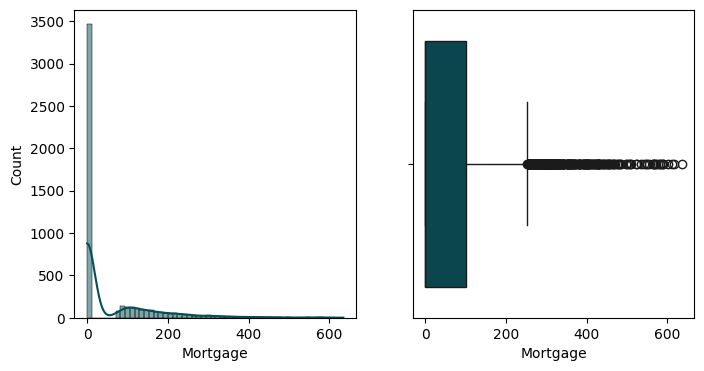

In [11]:
plt.figure(figsize=(8,4))
#sns.violinplot(x=df['Mortgage'])
plt.subplot(1,2,1)
sns.histplot(df['Mortgage'],kde=True)
plt.subplot(1,2,2)
sns.boxplot(x=df['Mortgage'])
plt.show()

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- The distribution is heavily right skewed, that means most of the data points are concentrated on the left side.
- We can observe most of the customers (around 3500) do not have any mortgages, and only a few have mortgages over  600k USD.
- We have many outliers where the mortgage amount is greater than 250k.But these amounts look genuine so we will keep them as they are.

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Ans2. Customers with creditcards</p></u></h3>

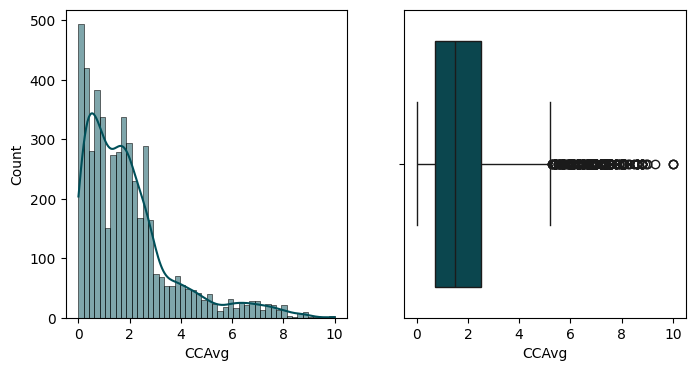

In [12]:
plt.figure(figsize=(8,4))
#sns.violinplot(x=df['Mortgage'])
plt.subplot(1,2,1)
sns.histplot(df['CCAvg'],kde=True)
plt.subplot(1,2,2)
sns.boxplot(x=df['CCAvg'])
plt.show()

In [13]:
df[df['CCAvg']>0].shape[0]

4894

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

<b>Assumption:</b> We do not have a feature that directly indicates whether a customer has a credit card. We’ll assume that if the CCAvg (average monthly credit card spending) is zero, the customer does not have a credit card.
- The distribution is right-skewed, meaning most customers spend very little or nothing on their credit cards.
- The median credit card spending is just under 2000 USD per month.
- The number of customers with a credit card is 4894.
- There are several outliers where some customers spend more than 5000 USD/month, and only a few spend nearly 10000 USD/month. These outliers appear to be genuine, so we won’t make any changes, but for safety, we could double-check the extreme outliers with the bank.

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Ans3. strong correlation with the target attribute</p></u></h3>

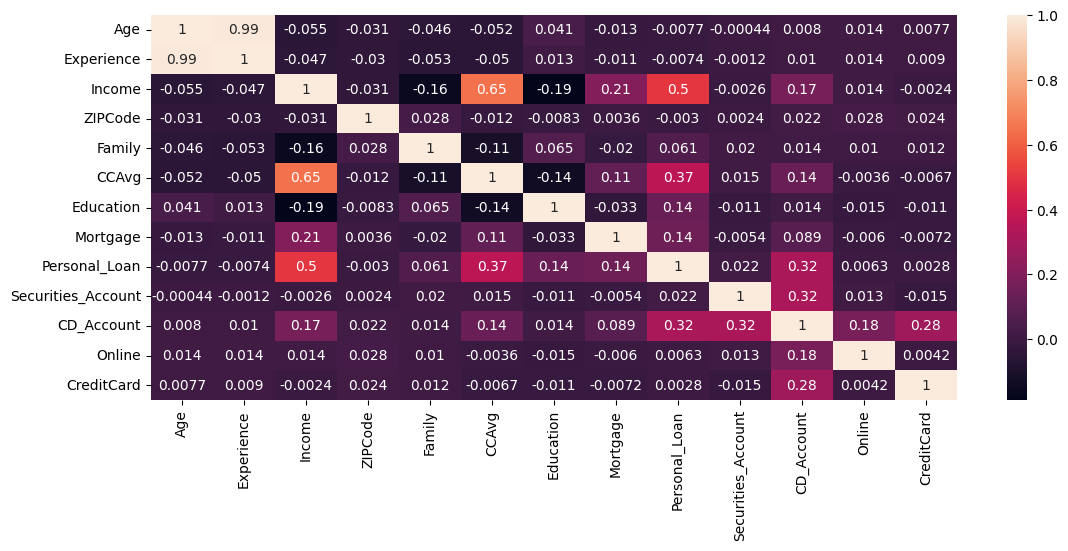

In [14]:
plt.figure(figsize=(13,5))
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.show() #Income has the highest correlation with target variable personal loan

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- Age and experience are highly correlated (.99), which could lead to multicollinearity issues, so we need to examine these two columns. 
- Income and CCAvg have a moderately high postive correlation (0.65).
- Personal Loan shows a moderate positive correlation with Income (0.50).
- Personal Loan shows low-to-moderate positive correlation with CCAvg(0.37) and CD_Account(0.32).

From our observations we can say our target variable has noticible correlation with Income, CCAvg and CD_Account.

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Ans4. Personal Loan vs Age</p></u></h3>

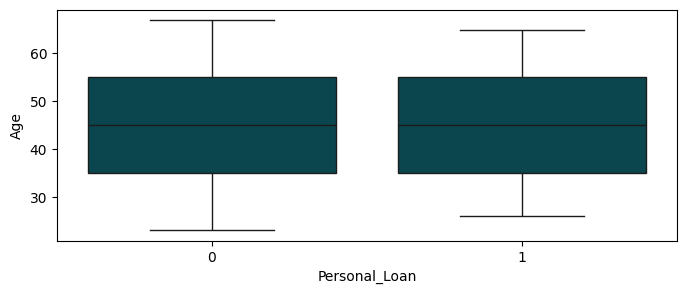

In [15]:
plt.figure(figsize=(8,3))
sns.boxplot(data=df,y='Age',x='Personal_Loan')
plt.show()

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

Based on this plot alone, it appears that age may not be a strong determinant in whether a person takes a personal loan or not, as both categories share a very similar age distribution. 

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Ans5. Personal Loan vs Education</p></u></h3>

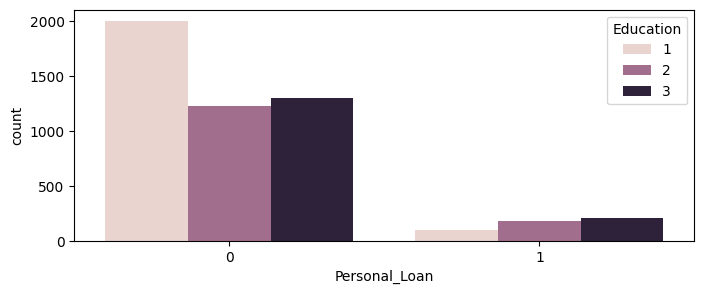

In [16]:
plt.figure(figsize=(8,3))
sns.countplot(data=df,hue='Education',x='Personal_Loan')
plt.show()

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- We can see that most customers did not take a personal loan, but among those who did, the likelihood is highest for customers with education level 3, followed by level 2, and then level 1. This suggests that in some extent education level impacts personal loan decisions, with higher-educated individuals being more likely to opt for personal loans.

# Visualization

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Univariate Analysis</p> </h3>

Technically, all our features are numerical, but functionally we have two sets of features:
- numerical (continuous values)
- categorical values (binary format).

To avoid writing the same code multiple times, we’ll create two functions to generate the appropriate plots for each type of feature.

In [17]:
def numeric_feature_univariate_plot(feature):
    plt.figure(figsize=(8, 3))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)

    # Histogram with KDE
    plt.subplot(1, 2, 2)
    sns.histplot(df[feature], kde=True, bins=30)

    # Calculate mean and median
    mean = df[feature].mean()
    median = df[feature].median()

    # Plot mean and median as vertical lines
    plt.axvline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='red', linestyle='-', label=f'Median: {median:.2f}')
    plt.title(f'Histogram with KDE of {feature}')
    plt.xlabel(feature)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
def categorical_feature_univariate_plot(feature):

    plt.figure(figsize=(8, 3))

    # Count plot
    plt.subplot(1, 2, 1)
    sns.countplot(x=df[feature], palette='viridis')
    plt.title(f'Count Plot of {feature}')
    plt.xlabel(feature)
    plt.xticks(rotation=90)

    # Pie chart for category distribution in percentage
    plt.subplot(1, 2, 2)
    df[feature].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Pie Chart of {feature}')
    plt.ylabel('')  # Hide the y-label
    
    plt.tight_layout()
    plt.show()


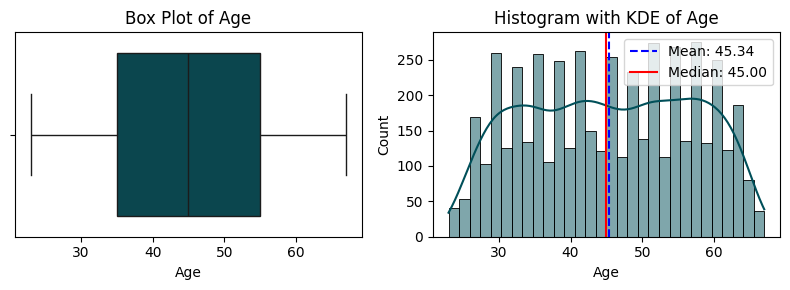

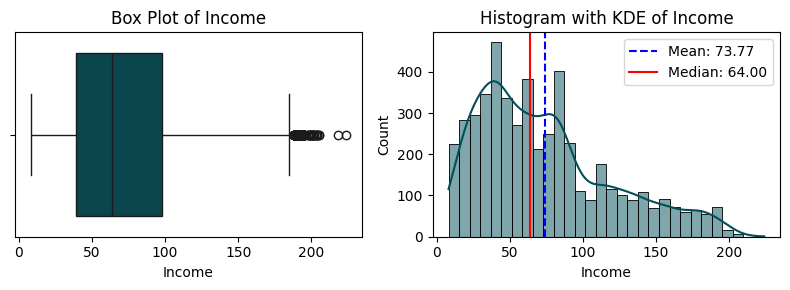

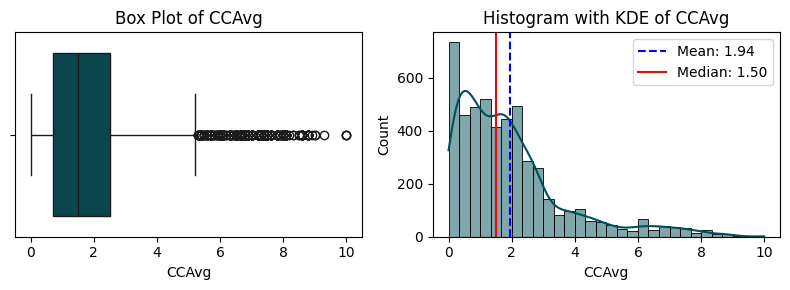

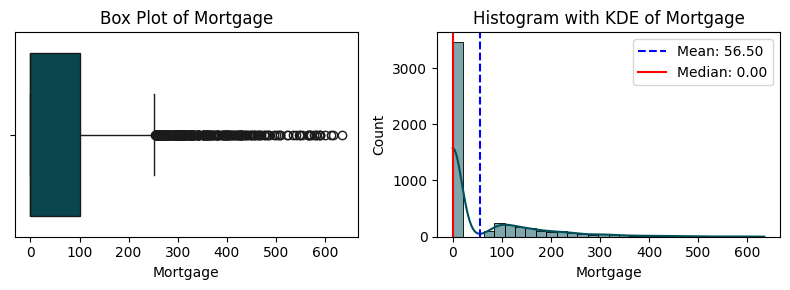

In [18]:
numeric_columns = ['Age','Income','CCAvg','Mortgage']

for feature in numeric_columns:
    numeric_feature_univariate_plot(feature)

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- Age:

    - Most customers are in their late 30s to early 50s, with a fairly even distribution across this age range.
    - There are no extreme outliers, suggesting a balanced age distribution.

- Income:

    - There are many outliers, with several customers earning over 180k per year.
    - The median income is 64k, meaning half of the customers earn less than 64k.
    - The distribution is right-skewed, with the mean pulled higher by high-income outliers.

- CCAvg:

    - This column represents average monthly credit card spending. Most customers spend less than 3k per month.
    - A few customers have significantly higher spending, up to 10k per month.
    - The distribution is skewed to the right.

- Mortgage:

    - A significant number of customers have high mortgage balances, exceeding 250k.
    - The median mortgage balance is zero, suggesting that a large number of customers don't have mortgages.
    - The distribution is highly skewed to the right.

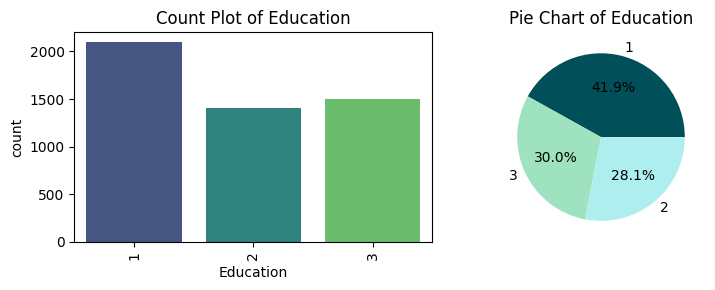

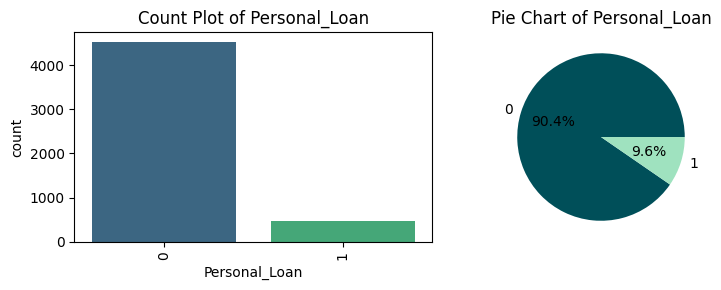

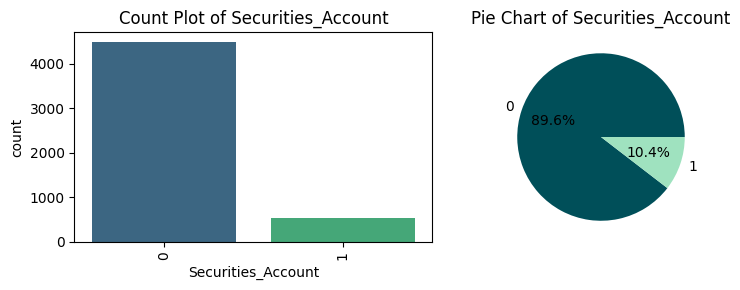

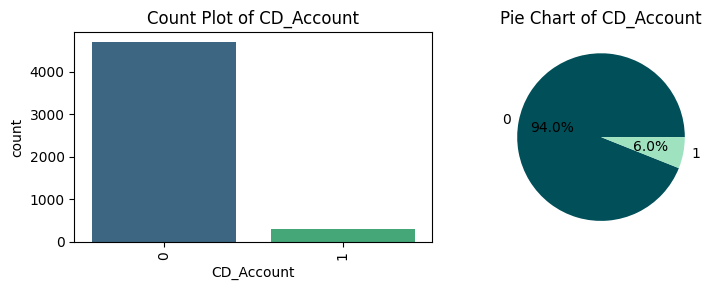

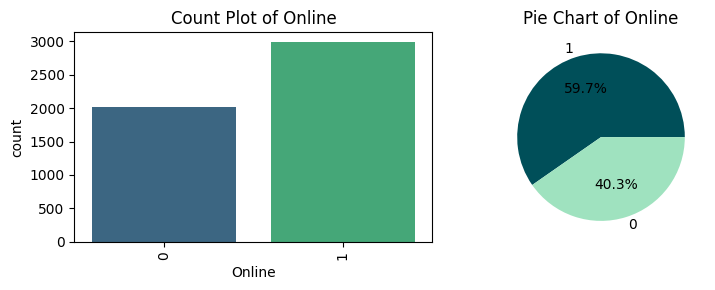

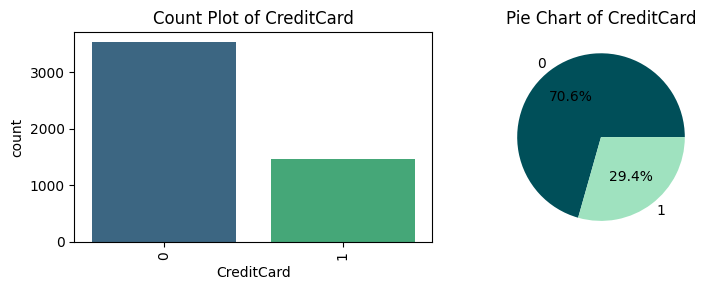

In [19]:
categorical_columns = ['Education','Personal_Loan','Securities_Account','CD_Account','Online','CreditCard']

for feature in categorical_columns:
    categorical_feature_univariate_plot(feature)

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- Education: 41.9% of customers have an undergraduate education, 28.1% are graduates, and 30% have advanced-level education.
- Personal Loan: Our target variable shows that the data is imbalanced, with only 9.6% of customers having taken personal loans. We need to account for this imbalance when building the model.
- Securities Account: 10.4% of customers have a securities account.
- Certificate of Deposit Account: 6% of customers hold a certificate of deposit account.
- Internet Banking: 40.3% of customers do not use internet banking services, so majority uses net banking.
- Credit Card: 29.4% of customers use a credit card issued by another bank.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Bivariate Analysis</p> </h3>

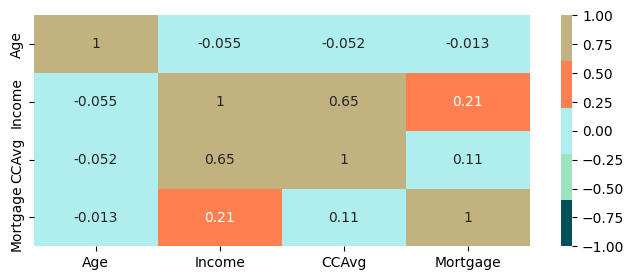

In [20]:
plt.figure(figsize=(8, 3))
sns.heatmap(df[numeric_columns].corr(),vmin=-1, vmax=1, annot=True, cmap=custom_cmap)
plt.show()

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- Income is moderately correlated with CCAvg, while the other columns do not show significant correlation.
- This correlation is not very high, and since decision trees are not very sensitive to multicollinearity, we will not take any action based on this.

<b> Since Personal Loan is our target variable, we will analyze how each feature behaves in relation to it.</b>

In [21]:
def plot_numerical_vs_target(feature, target):

    plt.figure(figsize=(12, 3))

    # Box plot comparing the feature distribution for each class of the target
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f'Box Plot of {feature} by {target}')

    # KDE plot to compare distributions
    plt.subplot(1, 2, 2)
    sns.kdeplot(df[df[target] == df[target].unique()[0]][feature], label=f'{target} = {df[target].unique()[0]}', fill=True)
    sns.kdeplot(df[df[target] == df[target].unique()[1]][feature], label=f'{target} = {df[target].unique()[1]}', fill=True)
    plt.title(f'Distribution of {feature} by {target}')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_categorical_vs_target(feature, target):
    
    plt.figure(figsize=(12, 3))

    # Count plot showing distribution of feature across target classes
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue=target, data=df)
    plt.title(f'Count Plot of {feature} by {target}')

    # Stacked bar chart to show proportions
    plt.subplot(1, 2, 2)
    feature_target_ct = pd.crosstab(df[feature], df[target], normalize='index')
    feature_target_ct.plot(kind='bar', stacked=True, ax=plt.gca(), alpha=0.8)
    plt.title(f'Stacked Bar Chart of {feature} by {target}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()

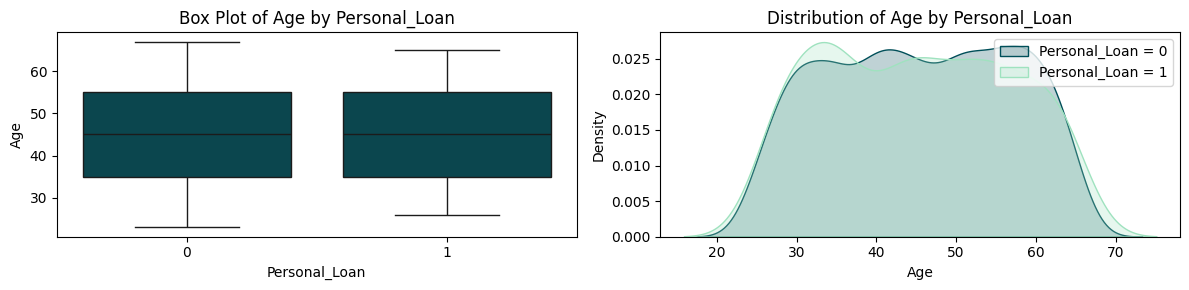

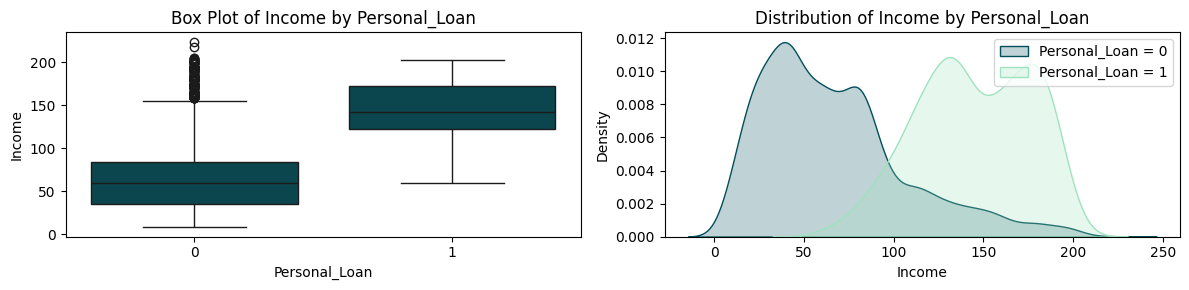

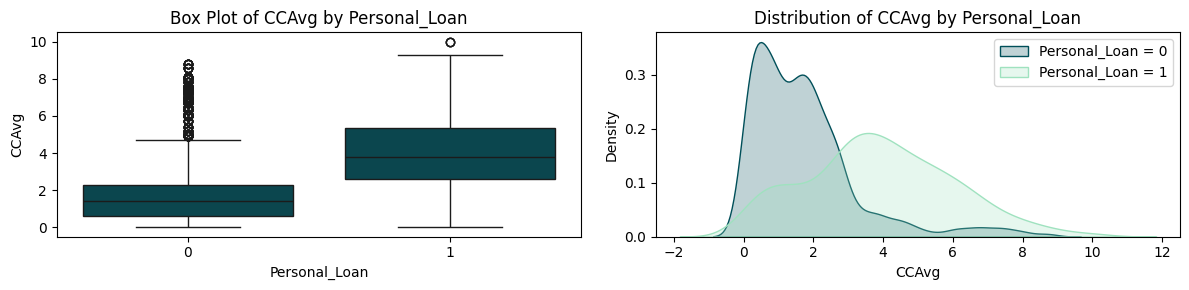

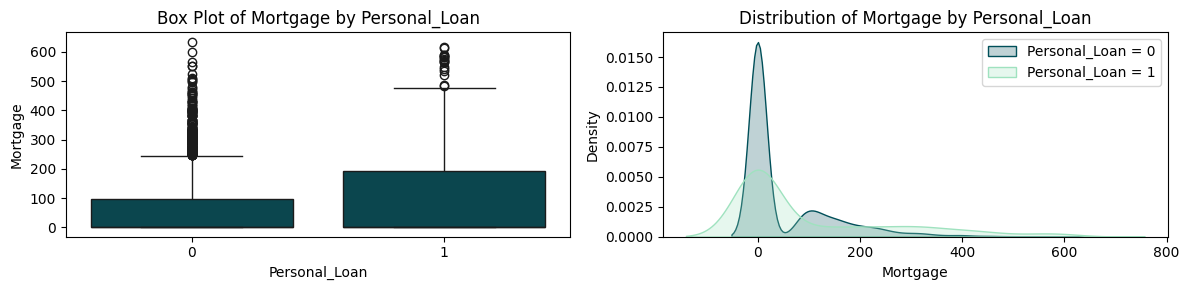

In [22]:
for feature in numeric_columns:
    plot_numerical_vs_target(feature, 'Personal_Loan')

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- Age vs Personal Loan: The median age for both loan takers and non-loan takers is around 45 years, with similar interquartile range (IQR), minimum, maximum, and overall distribution. This suggests that age isn’t a strong predictor of whether a customer will take a personal loan.
- Income vs Personal Loan: Customers who did not take a personal loan generally have lower incomes, with a few higher-income outliers. The median income for loan takers is much higher (around 150k). Non-loan takers peak around 40k, while loan takers have two peaks at approximately 125k and 180k. This suggests that income is a strong differentiator between loan takers and non-takers.
- CCAvg vs Personal Loan: Average credit card spending clearly have some influence in loan decisions. Loan takers have a median spending of 4k, compared to below 2k for non-loan takers. While there are outliers (some non-loan takers spend more than 5k). The distribution highlights a clear difference,incase of non-loan takers the mode value is below 1k, while loan takers mode is around 4k, indicating that higher spending may have some influence in loan taking decision.
- Mortgage vs Personal Loan: Both groups have a mode of 0 for mortgage, with right-skewed distributions. Although loan takers show a wider IQR, there’s no clear pattern from this feature to predict personal loan decisions.

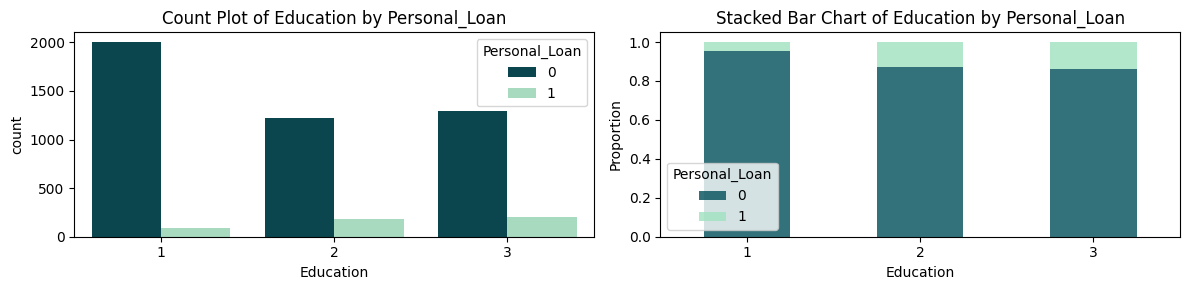

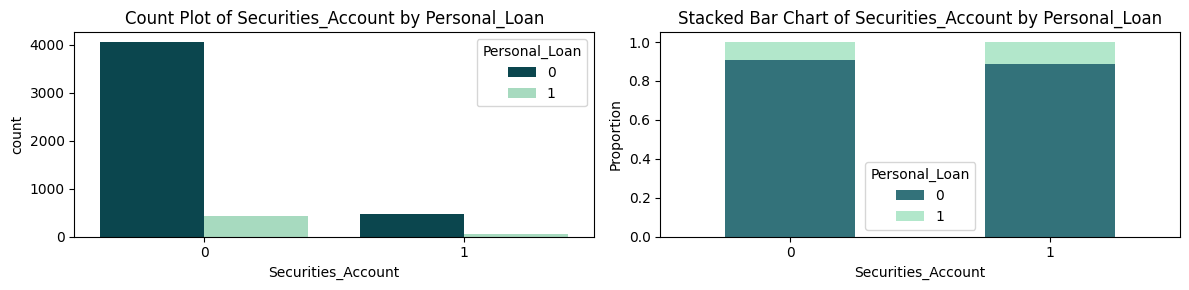

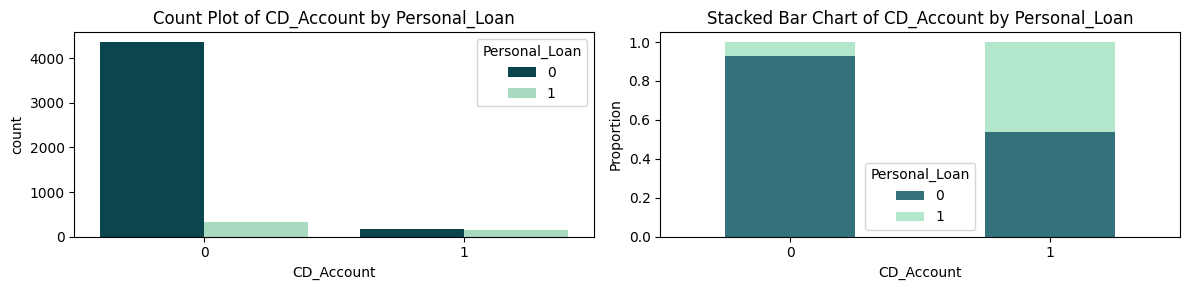

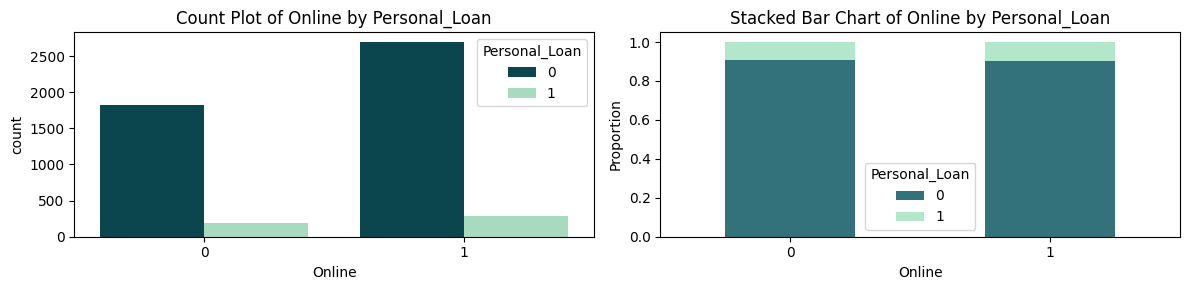

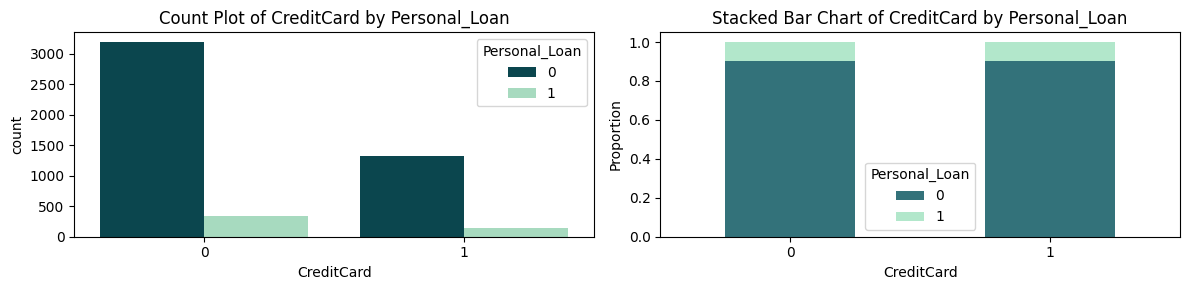

In [23]:
# Plot categorical features vs target
for feature in categorical_columns:
    if feature != 'Personal_Loan':
        plot_categorical_vs_target(feature, 'Personal_Loan')

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

- Education vs Personal Loan: Most customers who did not take a personal loan have an education level of 1 (Undergrad). Both in terms of number and proportion, undergraduates took the fewest personal loans. This suggests that customers with higher education levels (2 or 3) are more likely to take a personal loan.
- Securities Account vs Personal Loan: While the overall number of customers taking personal loans is low in both groups (those with and without a securities account), proportionally, customers with a securities account are slightly more likely to take a loan.
- CD Account vs Personal Loan: Customers with a certificate of deposit account are significantly more likely to take a personal loan, with nearly 50% opting for it. In contrast, customers without a CD account are much less likely to take a loan.
- Online vs Personal Loan: This feature doesn’t provide a clear indication of whether having an internet banking option influences the decision to take a personal loan. There is no strong pattern here.
- Credit card vs personal loan: Similarly, whether a customer has a credit card from another bank doesn’t seem to affect the likelihood of taking a personal loan. The proportions are almost the same for both groups.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">MultiVariate Analysis</p> </h3>

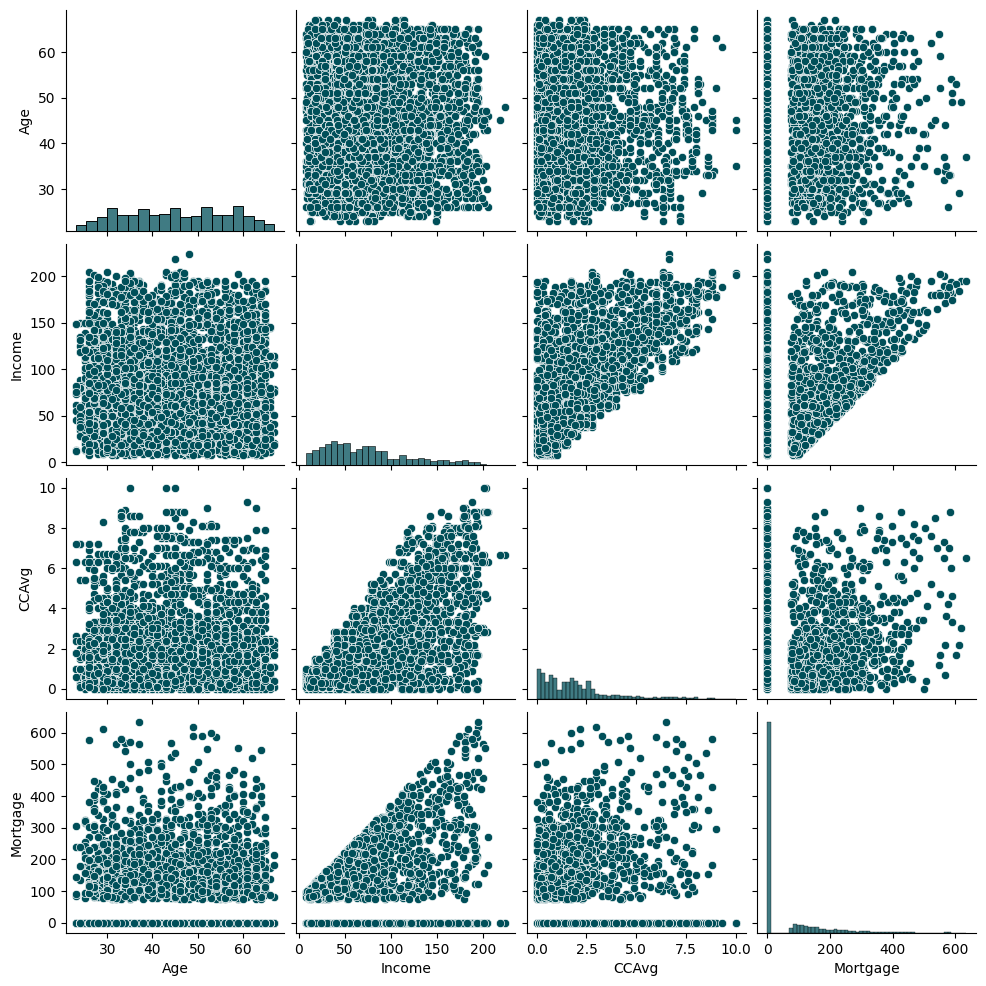

In [24]:
sns.pairplot(df[numeric_columns])
plt.show()

<h3><u style="color:gray;"><p style="color:gray; font-family:calibri; font-size:130%; text-align:left;">Observations</p></u></h3>

Most of the graph does not show and pattern between them, however from below two graphs we can observe some pattern:
- Income vs Mortgage:
    - There is a positive correlation between Income and Mortgage: as Income increases, Mortgage amounts generally increase as well. This makes sense since individuals with higher incomes are more likely to qualify for and take out larger mortgages.
    - However, for some high-income individuals, mortgage levels stay low or do not follow the overall increasing pattern, suggesting that higher income does not always mean higher mortgage amounts.
    - More datapoints are clustered near low income, which suggests most customers has low income.
- Income vs CCAvg:
    - This plot shows a positive trend between Income and Credit Card Average Spending. As income rises, average credit card spending tends to increase. People with higher incomes typically spend more, which is reflected in the upward trend.
    - However, for some high-income individuals, CCAvg levels stay low or do not follow the overall increasing pattern, suggesting that higher income does not always mean higher spending habit.

## Data Preprocessing

* Missing value treatment
* Feature engineering (if needed)
* Outlier detection and treatment (if needed)
* Preparing data for modeling
* Any other preprocessing steps (if needed)

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Feature engineering:</p></u></h3>

As per the instruction we will use decision tree which is not very sensitive to multicollinearity but we might need to use this data for other models in future and also for better understanding let's handle high multicollinearity (>.8) by feature engineering.
- We can create a new feature using two correlated features.
- We can keep any of the two columns.
- We can do PCA and have a new column.

We have already seen the correlation between Age and Experience is high, however before handling the multicollinearity we will calculate VIF score.

In [25]:
X = df[['Age', 'Experience']]

X = sm.add_constant(X) #added constant term

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif

,Variable,VIF
0,const,428.339018
1,Age,86.679012
2,Experience,86.679012


VIF threshold value is 10. We can see Age and Experience are highly correlated. We can create a new feature by subtracting experience from age, but we have few experiences with negative value so we will not use this approach. For simplicity we will drop Experience column and use Age in our model.

In [26]:
df.drop(['Experience'], axis=1, inplace=True)

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Clustering:</p></u></h3>

Using the zipcode, we can gather more information about the customer’s location and potentially cluster them based on their proximity to each other. We can later check if this geographic information adds value in our analysis or helps improve the model’s performance.

In [27]:
def get_city_state(zip_code):
    result = nomi.query_postal_code(zip_code)
    return pd.Series([result.county_name, result.state_name, result.latitude, result.longitude])

In [28]:
zip_code_df = pd.DataFrame({
    'ZIPCode': df['ZIPCode'].unique()
})

In [29]:
zip_code_df[['county', 'state','latitude','longitude']] = zip_code_df['ZIPCode'].apply(get_city_state)
zip_code_df.sample(5,random_state=rn)

,ZIPCode,county,state,latitude,longitude
55,91335,Los Angeles,California,34.2007,-118.5391
63,95134,Santa Clara,California,37.4087,-121.9406
33,92672,Orange,California,33.4361,-117.6231
462,90068,Los Angeles,California,34.1156,-118.3305
72,95617,Yolo,California,38.5494,-121.7253


In [30]:
zip_code_df[zip_code_df.longitude.isna()]

,ZIPCode,county,state,latitude,longitude
79,92717,NaN,NaN,NaN,NaN
210,93077,NaN,NaN,NaN,NaN
236,92634,NaN,NaN,NaN,NaN
276,96651,NaN,NaN,NaN,NaN
293,92709,NaN,NaN,NaN,NaN


Will try to find these missing zipcode from internet and handle the missing values

In [31]:
missing_zip_code_details={92717:{'county':'Orange','state':'California'},
                         93077:{'county':'Ventura','state':'California'},
                         92634:{'county':'Orange','state':'California'},
                         96651:{'county':'El Dorado','state':'California'},
                         92709:{'county':'Orange','state':'California'}}

for zipcode,values in missing_zip_code_details.items():
    zip_code_df.loc[zip_code_df['ZIPCode'] == zipcode, ['county', 'state']] = values['county'], values['state'] 

<i>Sources:</i> multiple sites from internet (example: https://www.unitedstateszipcodes.org/)

To replace the missing values in Latitude and Longitude, since these are continuous variables, I will use the mean values for each respective county.

In [32]:
county_means = zip_code_df.groupby('county')[['latitude', 'longitude']].transform('mean') #find mean for all the rows
#replace the missing rows
zip_code_df['latitude'].fillna(county_means['latitude'], inplace=True)
zip_code_df['longitude'].fillna(county_means['longitude'], inplace=True)

In [33]:
zip_code_df[zip_code_df.latitude.isna()]

,ZIPCode,county,state,latitude,longitude


We no longer have any missing values, so we can now merge this information back into our original dataframe.

In [34]:
df=pd.merge(df,zip_code_df,on="ZIPCode",how="inner")

In [35]:
df=df.drop('ZIPCode',axis=1)
df.head(5)

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,county,state,latitude,longitude
0,25,49,4,1.6,1,0,0,1,0,0,0,Los Angeles,California,34.1510,-118.0889
1,45,34,3,1.5,1,0,0,1,0,0,0,Los Angeles,California,33.7866,-118.2987
2,39,11,1,1.0,1,0,0,0,0,0,0,Alameda,California,37.8738,-122.2549
3,35,100,1,2.7,2,0,0,0,0,0,0,City and County of San Francisco,California,37.7195,-122.4411
4,35,45,4,1.0,2,0,0,0,0,0,1,Los Angeles,California,34.2283,-118.5368


In [36]:
df['state'].unique()

array(['California'], dtype=object)

As all the customers are from California state we can drop this column.

In [37]:
df=df.drop('state',axis=1)

People living in similar area might have similar personal loan or credit requirement so based on latitude and longitude we will try to create location based cluster and will check if that helps our model to do better prediction later.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Location Cluster using K means Clustering</p> </h3>

In [38]:
#Number of counties can give us some idea about the cluster number
df.county.nunique()

38

Assuming there will be at least 2-3 counties in each cluster, we can estimate that the maximum number of clusters will be around 15.

In [39]:
X_cluster = df[['latitude', 'longitude']]

# Scale latitude and logitude
X_scaled_cluster = scaler.fit_transform(X_cluster)

wcss = []
silhouette_scores = []
range_clusters = range(2, 16)  # Trying different cluster numbers (2 to 15)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=rn)
    kmeans.fit(X_scaled_cluster)
    wcss.append(kmeans.inertia_)
    cluster_labels = kmeans.predict(X_scaled_cluster)
    silhouette_avg = silhouette_score(X_scaled_cluster, cluster_labels)
    silhouette_scores.append(silhouette_avg)

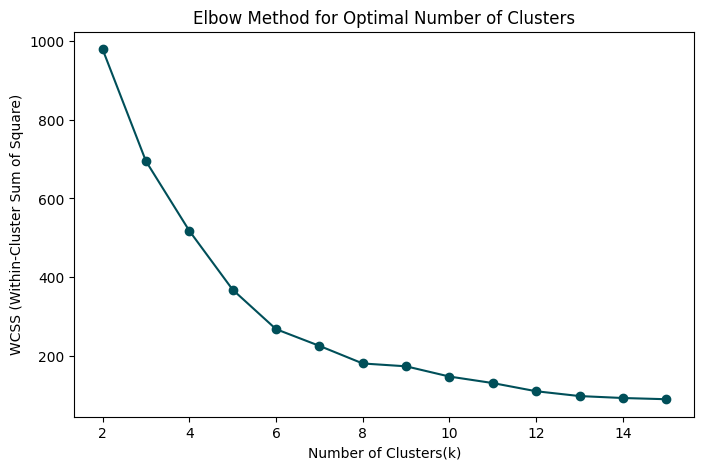

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('WCSS (Within-Cluster Sum of Square)')
plt.show()

From above plot it seems like the optimal k value could be 5 or 6

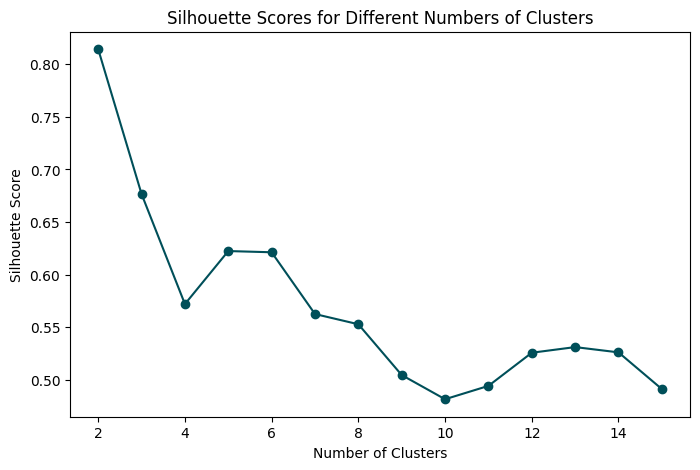

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Silhouette score is highest for k=2, where for k=3,5 and 6 the score is reasonable, considering both elbow plot and silhouette score we will go for k=6; If we have time we can also try for k=2/3/5 and see how the model performs.

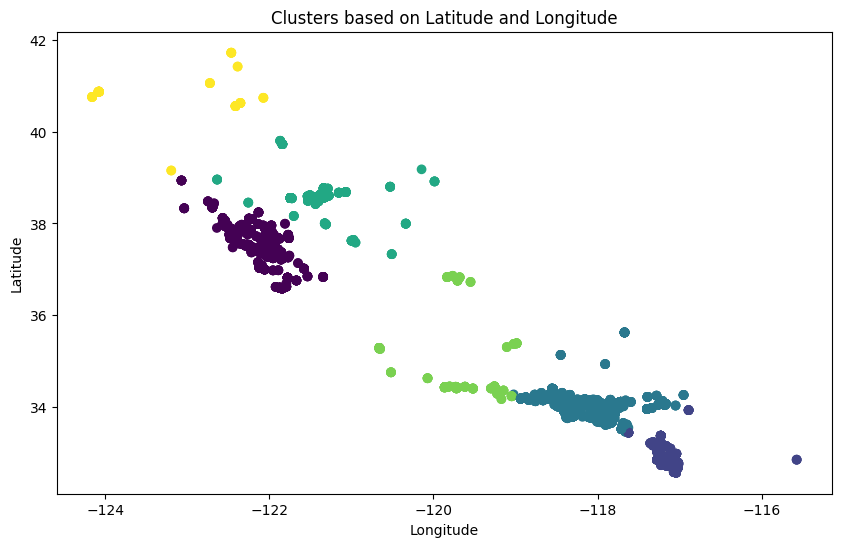

In [42]:
optimal_k = 6

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=rn)
df['location_cluster'] = kmeans_final.fit_predict(X_scaled_cluster)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['location_cluster'])
plt.title('Clusters based on Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [43]:
df.sample(5,random_state=rn)

,Age,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,county,latitude,longitude,location_cluster
1501,30,35,2,0.3,2,0,0,1,0,0,1,San Diego,32.9555,-117.2252,1
2586,47,149,4,6.1,1,0,1,0,0,0,1,Orange,33.5085,-117.6565,2
2653,30,121,2,3.1,1,408,0,0,0,1,0,Alameda,37.5735,-122.0469,0
1055,31,62,1,1.0,1,0,0,1,0,1,0,Sacramento,38.6709,-121.1529,3
705,62,30,3,0.7,2,0,0,0,0,1,0,Alameda,37.8738,-122.2549,0


<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Scaling Data</p> </h3>

- We have 3 amount columns here, all are in thousands dollar format, so we will keep them in same format.
-  CCAvg represents the monthly credit card spending, while Income represents yearly income. To align these two columns, we will convert CCAvg to yearly spending.

In [44]:
df['CCAvg']=df['CCAvg']*12

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Categorical to Numeric Value Conversion</p> </h3>

- Below columns are categorical but contain only binary values, so no changes are required:
    - Securities_Account
    - CD_Account
    - Online
    - CreditCard
    - Personal_Loan

- For the following columns, which are categorical but not in binary format:
    - Education: This feature has meaningful order (ordinal categorical), so no changes are needed.
    - County: The ‘county’, ‘latitude’, and ‘longitude’ columns were used to create the ‘location_cluster’ column, so we can drop these and use ‘location_cluster’ instead.
    - Location_Cluster: We could create dummy variables for this feature, but since we are using a decision tree model, it is not necessary.

All other features are numeric, so one-hot encoding is not required.

<h3><u style="color:green;"><p style="color:green; font-family:calibri; font-size:130%; text-align:left;">Data Preparation For Modeling:</p></u></h3>

In [45]:
data=df[['Age','Income','Family','CCAvg','Education','Mortgage','Securities_Account','CD_Account','Online','CreditCard','location_cluster','Personal_Loan']]
data.sample(5,random_state=rn)

,Age,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,location_cluster,Personal_Loan
1501,30,35,2,3.6,2,0,1,0,0,1,1,0
2586,47,149,4,73.2,1,0,0,0,0,1,2,1
2653,30,121,2,37.2,1,408,0,0,1,0,0,0
1055,31,62,1,12.0,1,0,1,0,1,0,3,0
705,62,30,3,8.4,2,0,0,0,1,0,0,0


<h4><u style="color:gray;"><p style="color:darkblue; font-family:calibri; font-size:130%; text-align:left;">Handle Imbalanced Target Variable:</p></u></h4>

Since Personal Loan has imbalanced data, we could use undersampling or oversampling techniques. However, these methods carry the risk of losing important features or generating similar data points. Instead, we will follow these steps:
- <b>Choosing the Right Model:</b> We will use a Decision Tree classifier and set the <b><i><span style="color:midnightblue;">class_weight="balanced"</span></i></b>. This will help the model account for the imbalance in the target variable.
- <b>Correctly Dividing the Train and Test Data:</b> While splitting the data into training and testing sets, we will use <b><i><span style="color:midnightblue;">stratify=y</span></i></b>. This ensures that the proportion of loan takers and non-takers is preserved in both training and testing sets.
- <b>Choosing the Right Evaluation Metric:</b> Our primary goal is to ensure that we do not miss potential loan applicants. To achieve this, we will optimize for <b><i><span style="color:midnightblue;">recall</span></i></b>. Maximizing recall will help us identify as many loan applicants as possible, even at the cost of false positives.

In [46]:
X = data.drop(["Personal_Loan"], axis=1)
y = data["Personal_Loan"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rn,  stratify=y)

In [47]:
print("Training set Data points: ", X_train.shape[0])
print("Test set Data points: ", X_test.shape[0])
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Training set Data points:  3500
Test set Data points:  1500
Percentage of classes in training set:
Personal_Loan
0    0.904
1    0.096
Name: proportion, dtype: float64
Percentage of classes in test set:
Personal_Loan
0    0.904
1    0.096
Name: proportion, dtype: float64


In [48]:
X.sample(5,random_state=rn)

,Age,Income,Family,CCAvg,Education,Mortgage,Securities_Account,CD_Account,Online,CreditCard,location_cluster
1501,30,35,2,3.6,2,0,1,0,0,1,1
2586,47,149,4,73.2,1,0,0,0,0,1,2
2653,30,121,2,37.2,1,408,0,0,1,0,0
1055,31,62,1,12.0,1,0,1,0,1,0,3
705,62,30,3,8.4,2,0,0,0,1,0,0


## Model Building

### Model Evaluation Criterion

We need to evaluate the model’s performance multiple times, so we should create functions to handle the repetitive code.

In [49]:
def model_evaluation(model, predictors, target):
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred)

    df_performance = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_performance

In [50]:
def plot_confusion_matrix(model, predictors, target, title):
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Model Building

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Default Decision Tree</p> </h3>

In [51]:
default_model = DecisionTreeClassifier(random_state=rn, class_weight="balanced") #our target variable is not balanced
default_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

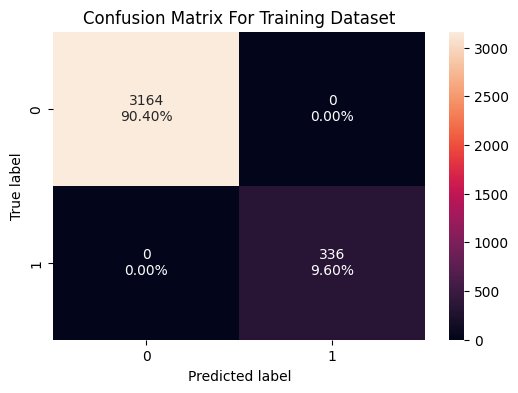

In [52]:
plot_confusion_matrix(default_model, X_train, y_train, "Confusion Matrix For Training Dataset")

In [53]:
default_model_performance_train_data= model_evaluation(default_model, X_train, y_train)
default_model_performance_train_data

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


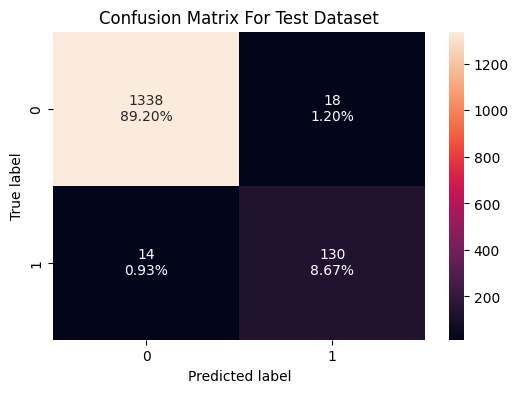

In [54]:
plot_confusion_matrix(default_model, X_test, y_test, "Confusion Matrix For Test Dataset")

In [55]:
default_model_performance_test_data=model_evaluation(default_model, X_test, y_test)
default_model_performance_test_data

,Accuracy,Recall,Precision,F1
0,0.978667,0.902778,0.878378,0.890411


The model performs significantly better on the training dataset compared to the test set, indicating that it is overfitting. To address this, we will work on improving the model’s performance and generalization to the test data.

## Model Performance Improvement

To improve the model, we will apply both Pre-Pruning and Post-Pruning techniques:
- <b>Pre Pruning:</b> We will stop the growth of the tree before it becomes overly complex and begins overfitting the data.
- <b>Post Pruning:</b> The model we have already built above will use that one and remove branches that do not provide significant information, using cost complexity pruning.

Let’s start by implementing the Pre-Pruning method:

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Decision Tree Pre Pruning</p> </h3>

We will find the best parameter values using hyperparameter tuning. For hyperparameter tuning we will use GridSearchCV.

In [56]:
pre_base_model = DecisionTreeClassifier(random_state=rn, class_weight="balanced")
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_leaf_nodes': [5, 10, 20, None],
    'max_features': [None, 'sqrt', 'log2', 0.5]
}
grid_search = GridSearchCV(estimator=pre_base_model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)
pre_pruned_model = grid_search.best_estimator_

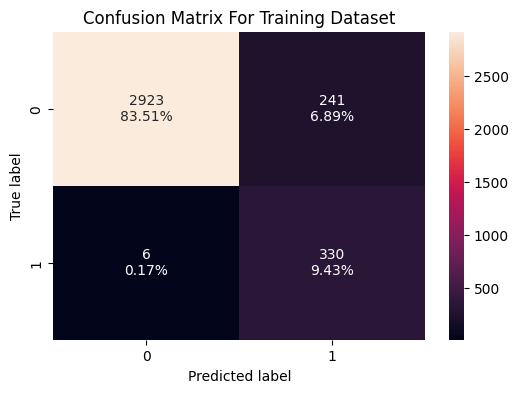

In [57]:
plot_confusion_matrix(pre_pruned_model, X_train, y_train, "Confusion Matrix For Training Dataset")

In [58]:
pre_pruned_model_performance_train_data=model_evaluation(pre_pruned_model, X_train, y_train)
pre_pruned_model_performance_train_data

,Accuracy,Recall,Precision,F1
0,0.929429,0.982143,0.577933,0.727674


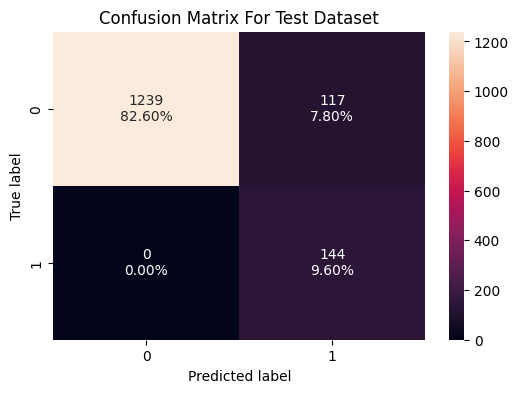

In [59]:
plot_confusion_matrix(pre_pruned_model, X_test, y_test, "Confusion Matrix For Test Dataset")

In [60]:
pre_pruned_model_performance_test_data=model_evaluation(pre_pruned_model, X_test, y_test)
pre_pruned_model_performance_test_data

,Accuracy,Recall,Precision,F1
0,0.922,1.0,0.551724,0.711111


In [61]:
feature_names = list(X_train.columns)
importances = pre_pruned_model.feature_importances_
indices = np.argsort(importances)

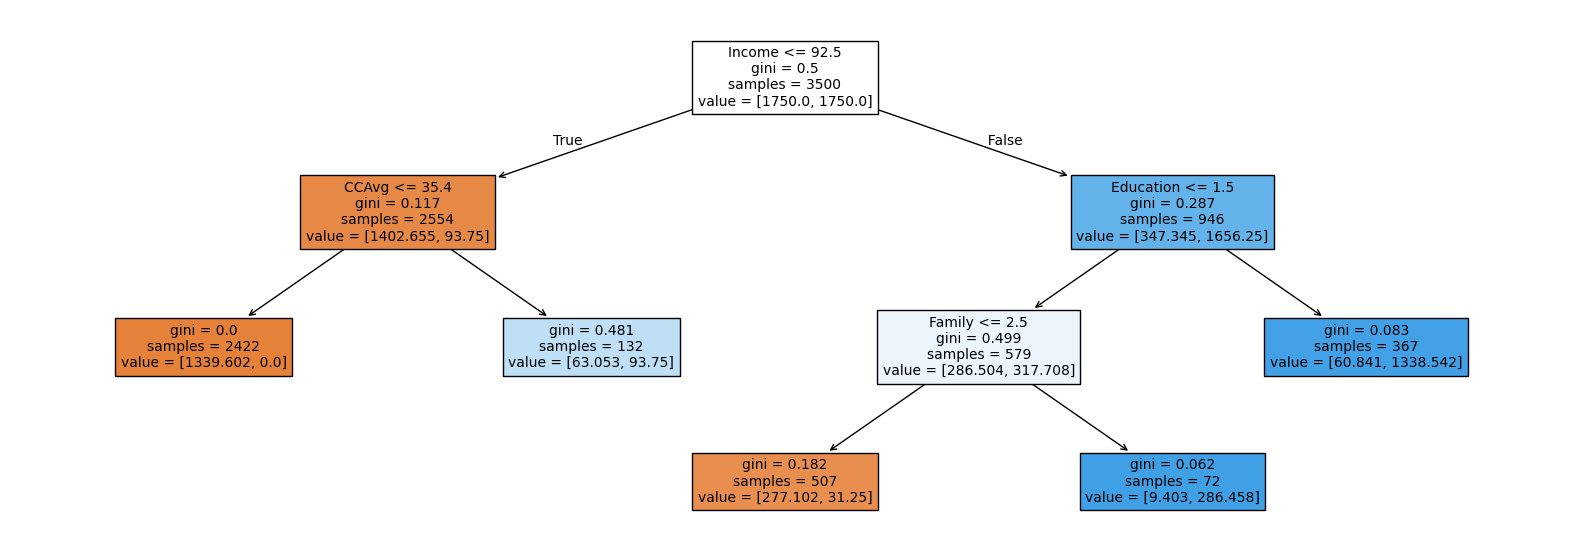

In [62]:
plt.figure(figsize=(20, 7))
out = tree.plot_tree(
    pre_pruned_model,
    feature_names=feature_names,
    filled=True,
    fontsize=10,
    node_ids=False,
    class_names=None,
)

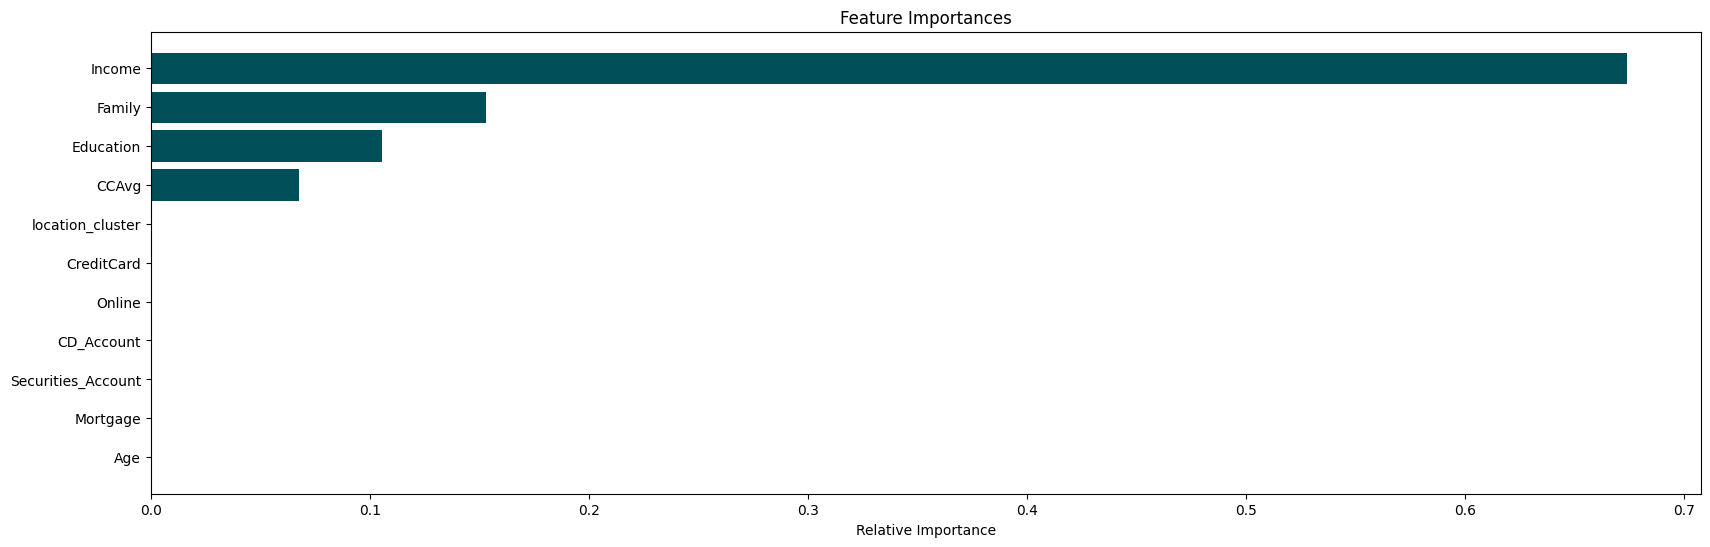

In [63]:
# plot feature importance for visualization
plt.figure(figsize=(20, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

We can see most imporatant features deciding whether person will take person loans or not are:
1. Income
2. Family
3. Education
4. CCAvg

Now we will build a model only using important feature and see if there is any improvement in the performance.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Decision Tree Pre Pruning Only using Important Features</p> </h3>

In [64]:
X_imp_features = data[['Income','Family','CCAvg','Education']]
y_imp_features = data['Personal_Loan']

X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp_features, y_imp_features, test_size=0.30, random_state=rn,  stratify=y)

In [65]:
imp_feature_model = DecisionTreeClassifier(random_state=rn, class_weight="balanced")

In [66]:
imp_grid_search = GridSearchCV(estimator=imp_feature_model, param_grid=param_grid, cv=5, scoring='recall')
imp_grid_search.fit(X_imp_train, y_imp_train)
imp_pre_pruned_model = imp_grid_search.best_estimator_

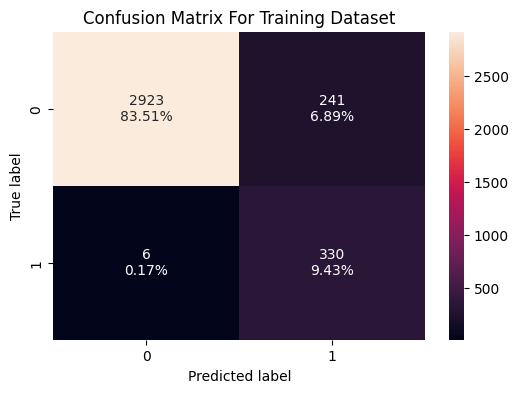

In [67]:
plot_confusion_matrix(imp_pre_pruned_model, X_imp_train, y_imp_train, "Confusion Matrix For Training Dataset")

In [68]:
imp_pre_pruned_model_performance_train_data=model_evaluation(imp_pre_pruned_model, X_imp_train, y_imp_train)
imp_pre_pruned_model_performance_train_data

,Accuracy,Recall,Precision,F1
0,0.929429,0.982143,0.577933,0.727674


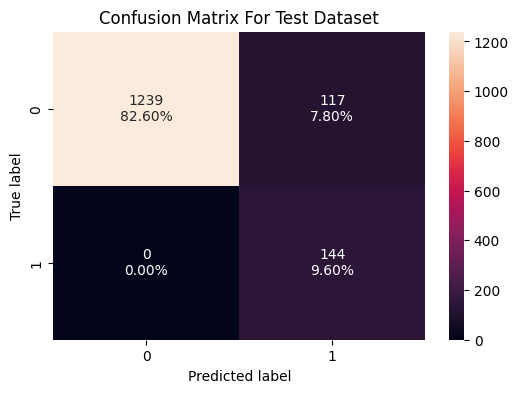

In [69]:
plot_confusion_matrix(imp_pre_pruned_model, X_imp_test, y_imp_test, "Confusion Matrix For Test Dataset")

In [70]:
imp_pre_pruned_model_performance_test_data=model_evaluation(imp_pre_pruned_model, X_imp_test, y_imp_test)
imp_pre_pruned_model_performance_test_data

,Accuracy,Recall,Precision,F1
0,0.922,1.0,0.551724,0.711111


In [71]:
imp_feature_names = list(X_imp_features.columns)
feature_importances = imp_pre_pruned_model.feature_importances_
imp_indices = np.argsort(feature_importances)

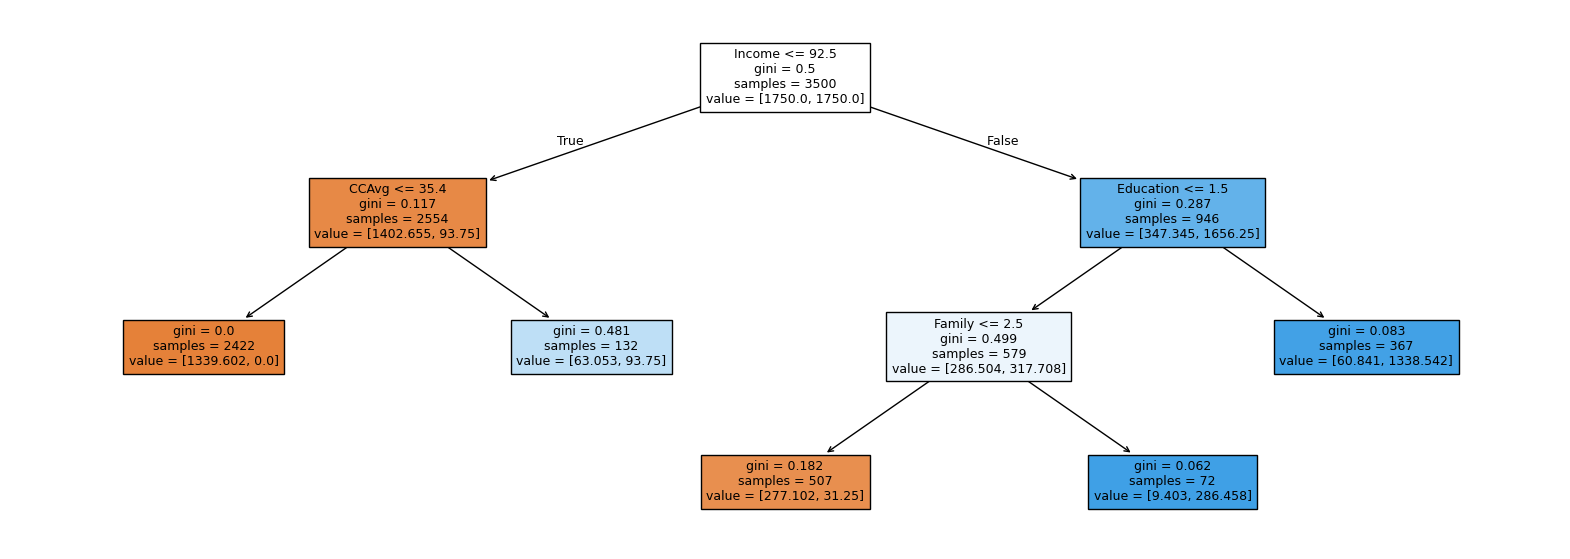

In [72]:
plt.figure(figsize=(20, 7))
out = tree.plot_tree(
    imp_pre_pruned_model,
    feature_names=imp_feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)

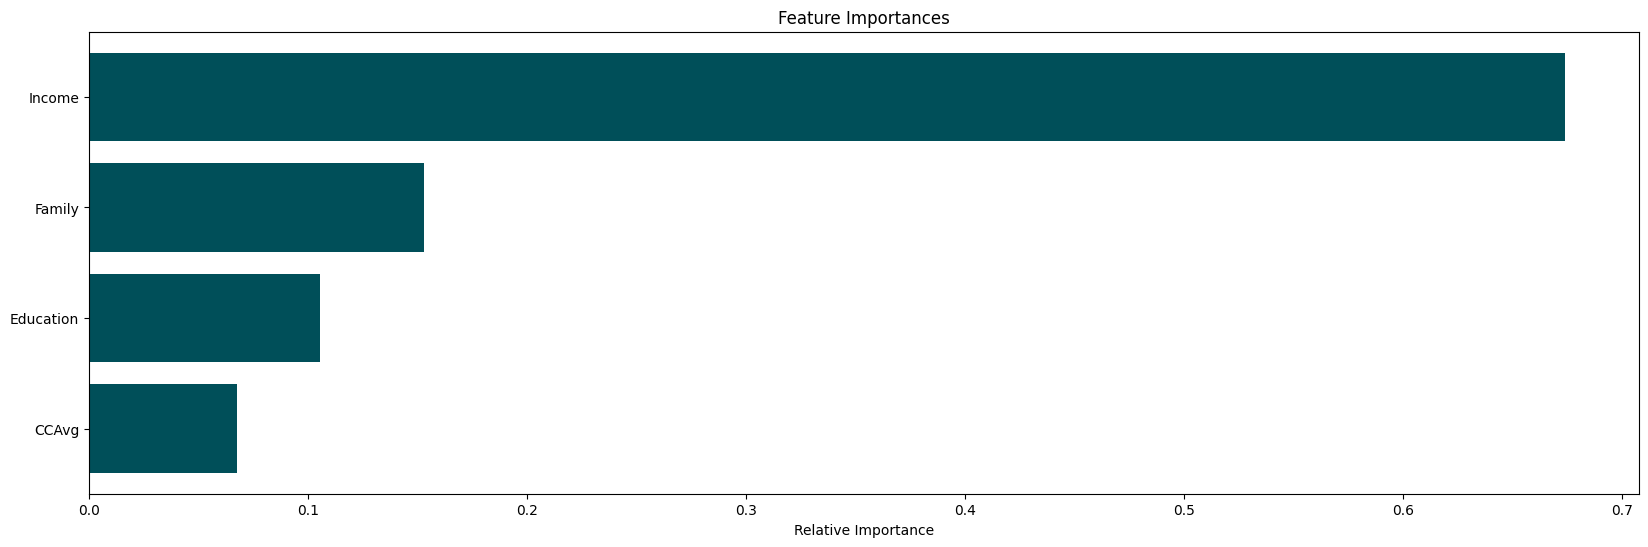

In [73]:
# plot feature importance for visualization
plt.figure(figsize=(20, 6))
plt.title("Feature Importances")
plt.barh(range(len(imp_indices)), feature_importances[imp_indices], align="center")
plt.yticks(range(len(imp_indices)), [imp_feature_names[i] for i in imp_indices])
plt.xlabel("Relative Importance")
plt.show()

We can see that the model’s performance has not improved significantly, but with fewer features, the model is less likely to overfit and is more efficient in terms of computation time. Therefore, between the previous model and this one, this is the better choice. Next, we’ll see if post-pruning can further enhance the model’s performance.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Decision Tree Post Pruning</p> </h3>

We will use cost complexity pruning for reducing the size of our decision tree (to balance complexity and performance of our model). Using<b> ccp_alpha </b>we will do this. When we increase the ccp_alpha we penalize the complexity (depth) of the the tree, which helps in pruning.

In [74]:
path = default_model.cost_complexity_pruning_path(X_train, y_train) # alphas and impurity values for each node
ccp_alphas, impurities = abs(path.ccp_alphas), path.impurities

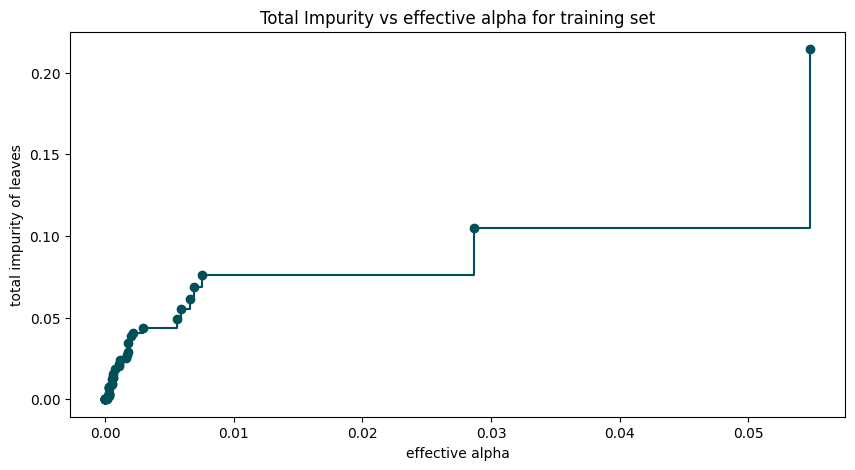

In [75]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [76]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=rn, ccp_alpha=ccp_alpha, class_weight="balanced")
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2857110844037618


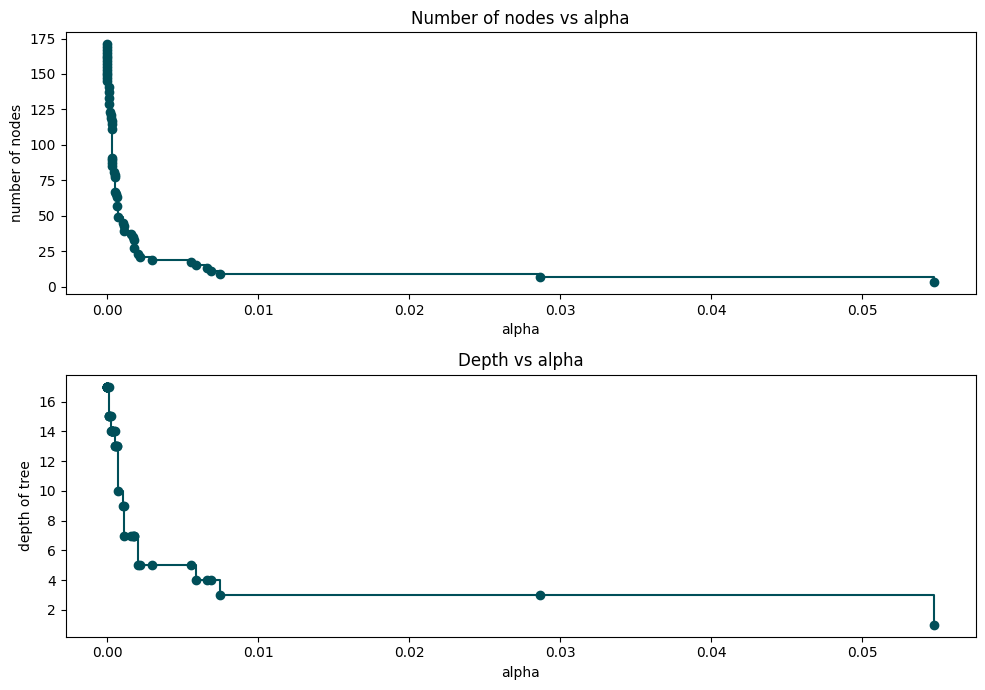

In [77]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Deeper trees can model more complex patterns but are prone to overfitting. Shallower trees are simpler and may not able to capture the complexity of the model, so we have to balance it out.

Evaluate the Accuracy of Each Pruned Model: To Know the accuracy of the models we will use recall as our evaluation metric

In [78]:
recall_train = []
for clf in clfs:
    pred_train = clf.predict(X_train)
    values_train = recall_score(y_train, pred_train)
    recall_train.append(values_train)

In [79]:
recall_test = []
for clf in clfs:
    pred_test = clf.predict(X_test)
    values_test = recall_score(y_test, pred_test)
    recall_test.append(values_test)

In [80]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

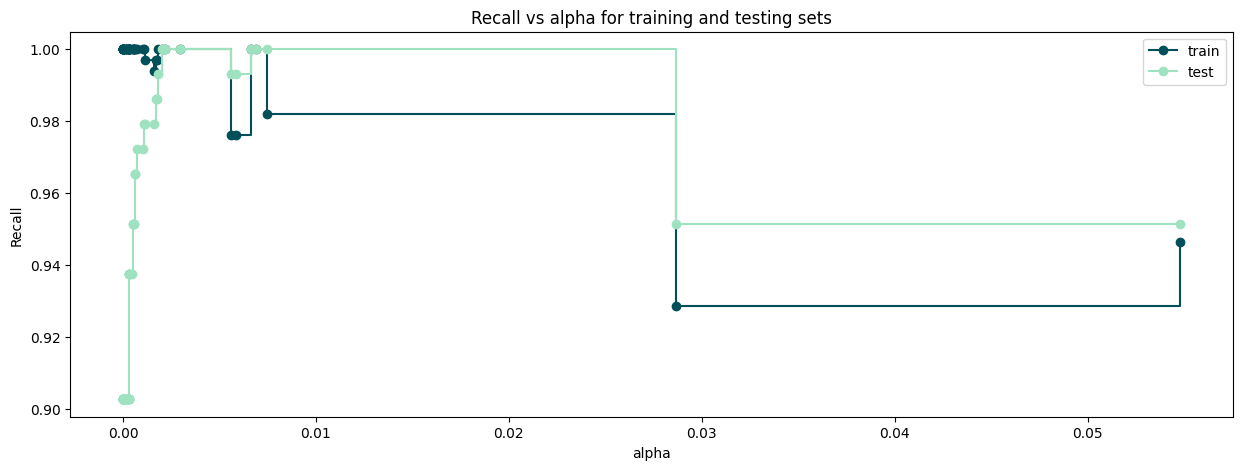

In [81]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(
    ccp_alphas, recall_train, marker="o", label="train", drawstyle="steps-post",
)
ax.plot(ccp_alphas, recall_test, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [82]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
best_model

DecisionTreeClassifier(ccp_alpha=0.0020324228398762244, class_weight='balanced',
                       random_state=42)

When "ccp_alpha=0.0020324228398762257" then we can see recall value for both text and train data is almost at highest. Graph and model both gave similar number, lets see the performance now.

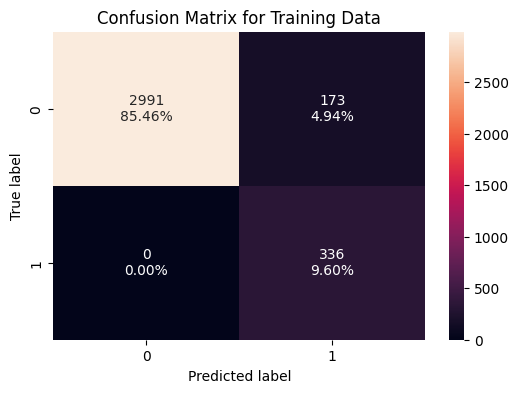

In [83]:
post_pruning_model = best_model
plot_confusion_matrix(post_pruning_model, X_train, y_train, "Confusion Matrix for Training Data")

In [84]:
post_pruned_model_performance_train_data=model_evaluation(post_pruning_model, X_train, y_train)
post_pruned_model_performance_train_data

,Accuracy,Recall,Precision,F1
0,0.950571,1.0,0.660118,0.795266


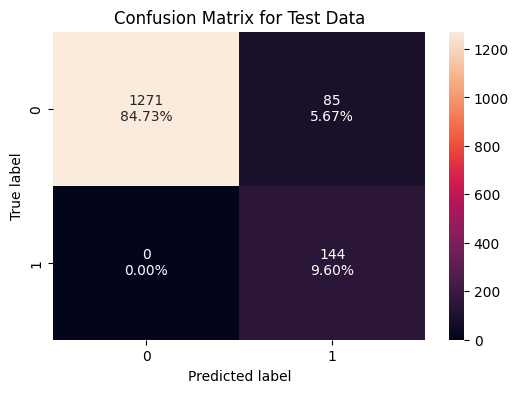

In [85]:
plot_confusion_matrix(post_pruning_model, X_test, y_test, "Confusion Matrix for Test Data")

In [86]:
post_pruned_model_performance_test_data=model_evaluation(post_pruning_model, X_test, y_test)
post_pruned_model_performance_test_data

,Accuracy,Recall,Precision,F1
0,0.943333,1.0,0.628821,0.772118


* In the post-pruned tree, the model is giving better performance and a generalized result since the recall scores on both the train and test data are same and precision scores are very close which shows that the model is able to generalize well on unseen data.

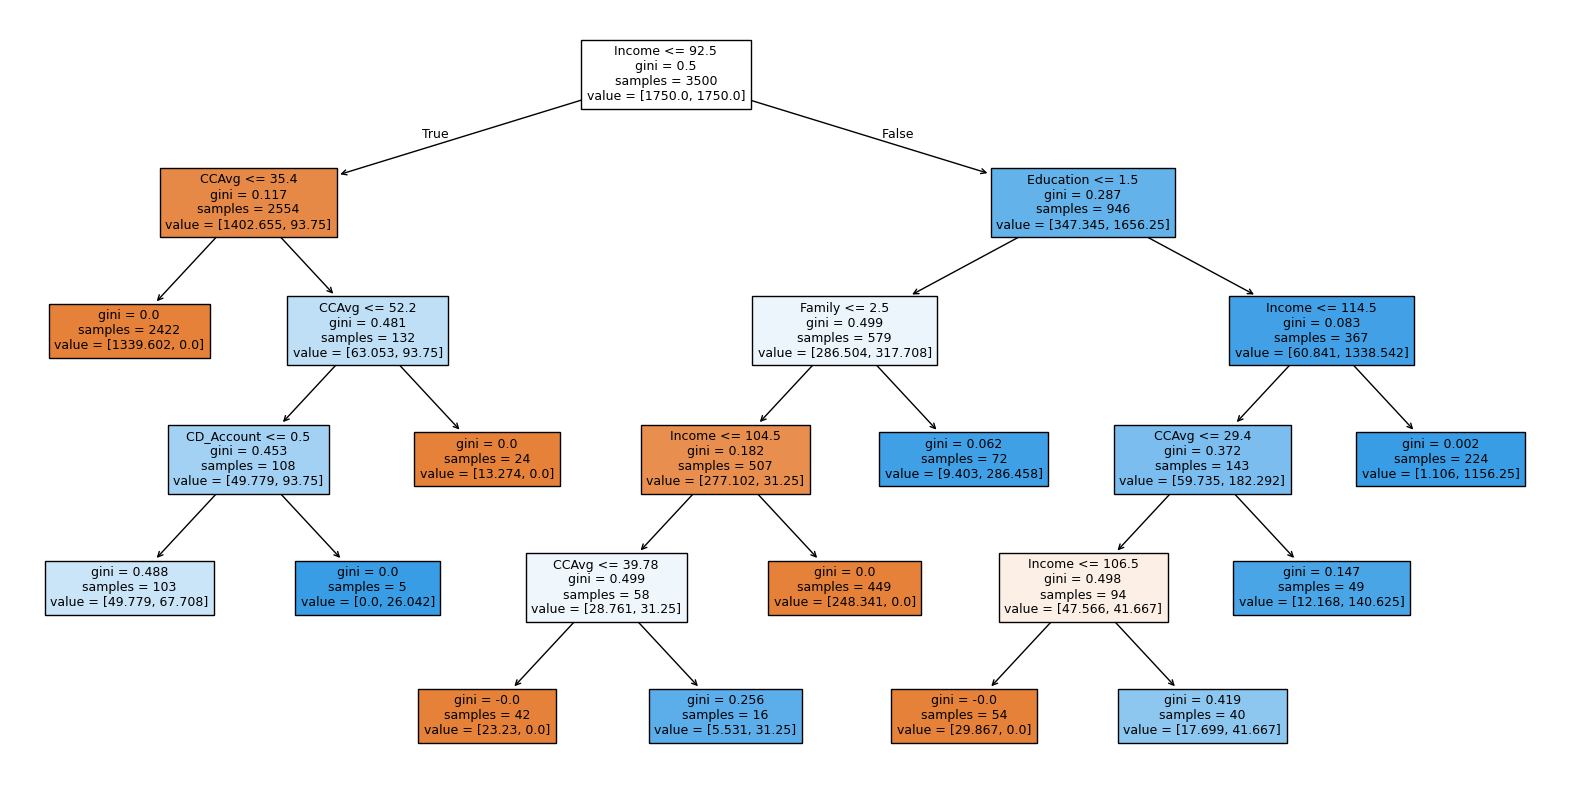

In [87]:
plt.figure(figsize=(20, 10))

out = tree.plot_tree(
    post_pruning_model,
    feature_names=feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
plt.show()

In [88]:
importances = post_pruning_model.feature_importances_
indices = np.argsort(importances)

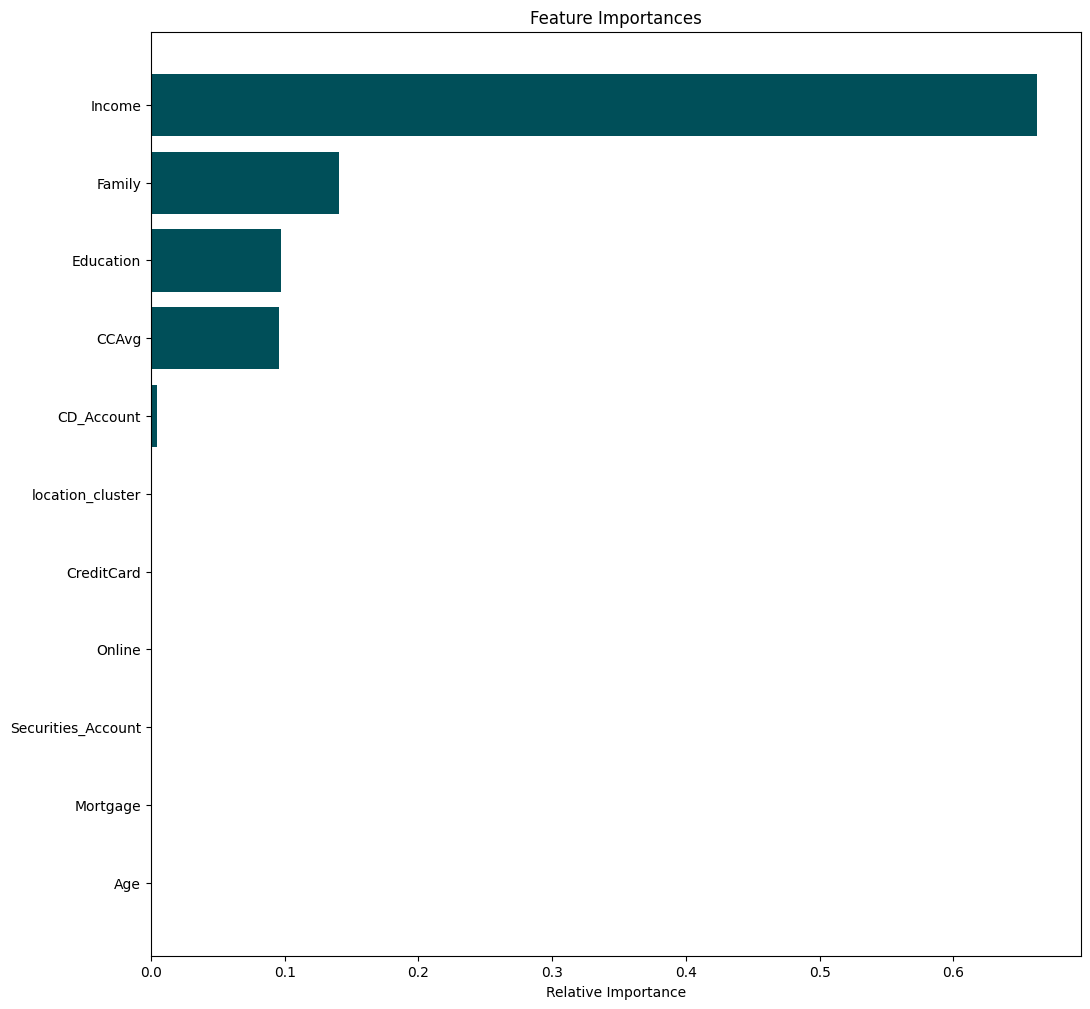

In [89]:
plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- We can see that the most important features from the analysis align with the pre-pruned models. We will now build a pre-pruned model using only the important features to assess its performance.

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Decision Tree Post Pruning Only using Important Features</p> </h3>

We have already conducted a detailed analysis for the post-pruned model. Here, we will build a model using the top four features and skip the detailed visual analysis.

In [90]:
clf_full = DecisionTreeClassifier(random_state=rn, class_weight='balanced') 
clf_full.fit(X_train, y_train) #first we need a full grown decision tree

# Get effective alphas for post-pruning
path = clf_full.cost_complexity_pruning_path(X_imp_train, y_imp_train)
ccp_alphas = path.ccp_alphas

# Define parameter grid for GridSearchCV
param_grid = {'ccp_alpha': ccp_alphas}

# Initialize the DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=rn)

# Initialize GridSearchCV for pruning with 'ccp_alpha'
grid_search = GridSearchCV(clf, param_grid, scoring='recall', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_imp_train, y_imp_train)

# Get the best parameters and best model
best_ccp_alpha = grid_search.best_params_['ccp_alpha']
best_model = grid_search.best_estimator_
best_model

Fitting 5 folds for each of 52 candidates, totalling 260 fits


DecisionTreeClassifier(ccp_alpha=0.0005499559548549312, random_state=42)

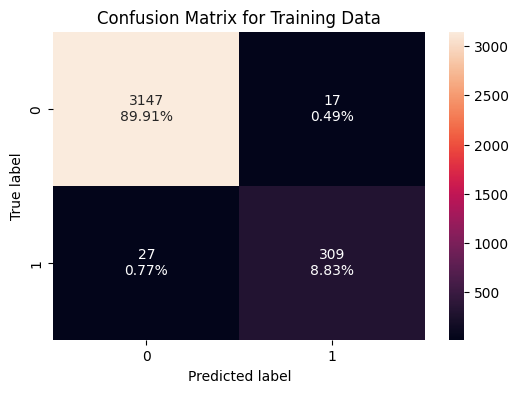

In [91]:
imp_post_pruning_model = best_model
plot_confusion_matrix(imp_post_pruning_model, X_imp_train, y_imp_train, "Confusion Matrix for Training Data")

In [92]:
imp_post_pruned_model_performance_train_data=model_evaluation(imp_post_pruning_model, X_imp_train, y_imp_train)
imp_post_pruned_model_performance_train_data

,Accuracy,Recall,Precision,F1
0,0.987429,0.919643,0.947853,0.933535


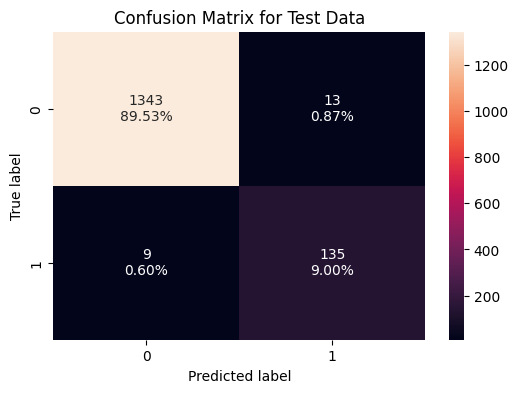

In [93]:
plot_confusion_matrix(imp_post_pruning_model, X_imp_test, y_imp_test, "Confusion Matrix for Test Data")

In [94]:
imp_post_pruned_model_performance_test_data=model_evaluation(imp_post_pruning_model, X_imp_test, y_imp_test)
imp_post_pruned_model_performance_test_data

,Accuracy,Recall,Precision,F1
0,0.985333,0.9375,0.912162,0.924658


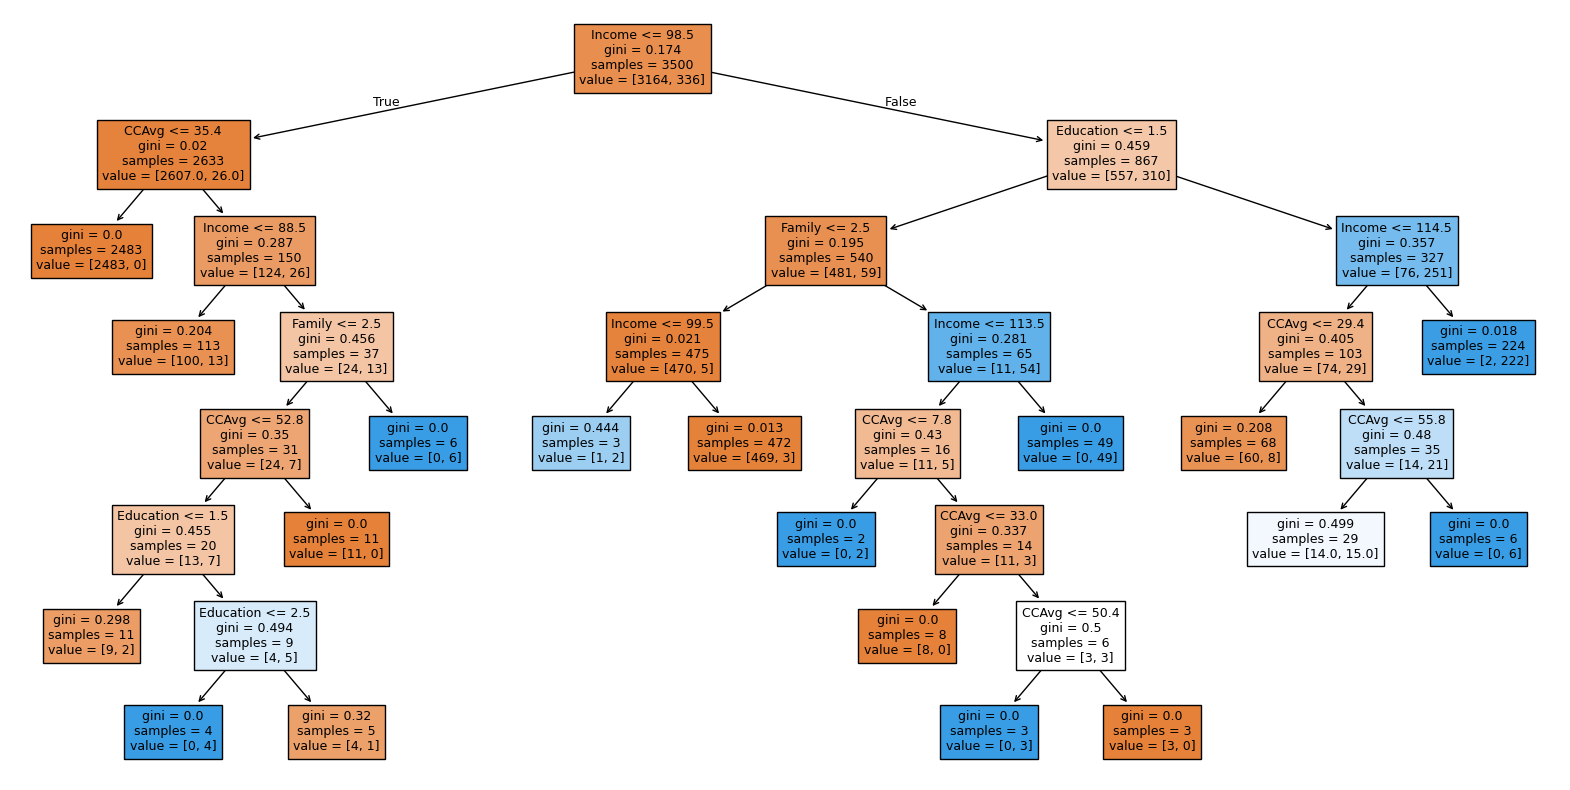

In [95]:
plt.figure(figsize=(20, 10))

out = tree.plot_tree(
    imp_post_pruning_model,
    feature_names=imp_feature_names,
    filled=True,
    fontsize=9,
    node_ids=False,
    class_names=None,
)
plt.show()

In [96]:
importances = imp_post_pruning_model.feature_importances_
indices = np.argsort(importances)

In [97]:
importances

array([0.45547019, 0.1537053 , 0.0559208 , 0.33490371])

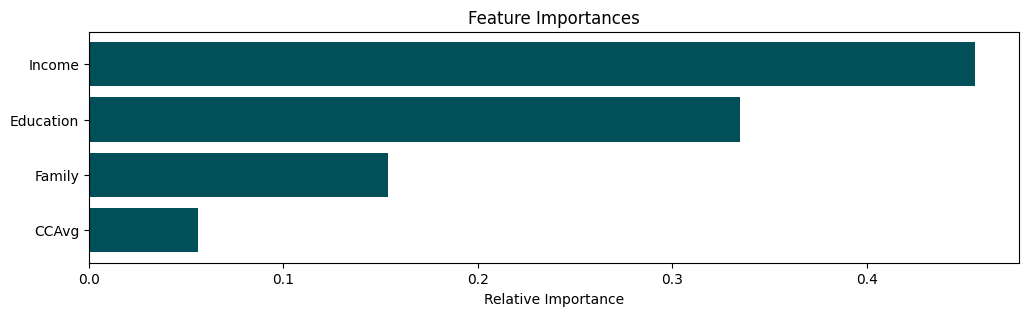

In [98]:
plt.figure(figsize=(12, 3))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [imp_feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

It is clear that our model performance has improved significantly, even though we are using only four features. However, we must remember that post-pruning is more time-intensive than pre-pruning. That said, in our case, the performance improvement is substantial, and the dataset is not large, so we can confidently say that this model is very good.

## Model Performance Comparison and Final Model Selection

In [99]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        default_model_performance_train_data.T,
        pre_pruned_model_performance_train_data.T,
        imp_pre_pruned_model_performance_train_data.T,
        post_pruned_model_performance_train_data.T,
        imp_post_pruned_model_performance_train_data.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree (sklearn default)",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Pre-Pruning Important Feature)",
    "Decision Tree (Post-Pruning)",
    "Decision Tree (Post-Pruning Important Feature)",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree (sklearn default),Decision Tree (Pre-Pruning),Decision Tree (Pre-Pruning Important Feature),Decision Tree (Post-Pruning),Decision Tree (Post-Pruning Important Feature)
Accuracy,1.0,0.929429,0.929429,0.950571,0.987429
Recall,1.0,0.982143,0.982143,1.000000,0.919643
Precision,1.0,0.577933,0.577933,0.660118,0.947853
F1,1.0,0.727674,0.727674,0.795266,0.933535


In [100]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [
        default_model_performance_test_data.T,
        pre_pruned_model_performance_test_data.T,
        imp_pre_pruned_model_performance_test_data.T,
        post_pruned_model_performance_test_data.T,
        imp_post_pruned_model_performance_test_data.T,
    ],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree (sklearn default)",
    "Decision Tree (Pre-Pruning)",
    "Decision Tree (Pre-Pruning Important Feature)",
    "Decision Tree (Post-Pruning)",
    "Decision Tree (Post-Pruning Important Feature)",
]
print("Test set performance comparison:")
models_test_comp_df

Test set performance comparison:


,Decision Tree (sklearn default),Decision Tree (Pre-Pruning),Decision Tree (Pre-Pruning Important Feature),Decision Tree (Post-Pruning),Decision Tree (Post-Pruning Important Feature)
Accuracy,0.978667,0.922000,0.922000,0.943333,0.985333
Recall,0.902778,1.000000,1.000000,1.000000,0.937500
Precision,0.878378,0.551724,0.551724,0.628821,0.912162
F1,0.890411,0.711111,0.711111,0.772118,0.924658


Considering all the scenarios, we can clearly say that the <b>"Decision Tree Post-Pruning Important Feature"</b> model is the best one. It is less complex than the "Decision Tree Post-Pruned model with all features", and its evaluation score on both the training and test datasets is very similar. This indicates that the model is able to generalize well and is not overfitting. However, it is important to consider the bank’s objectives, and based on those, the bank can choose the most suitable model.

<b> Which Model to choose?</b>
- If the bank’s primary focus is to capture potential customers and they want a simple model, I would recommend the Decision Tree Pre-Pruning model built using only the most important features.
- If the bank’s main goal is to capture potential customers while also reducing marketing expenses by minimizing false positives, and they do not mind the complexity of the model, then the Decision Tree Post-Pruning model with all features would be the best choice. This model achieves a recall score of 1 and has a better precision score compared to the pre-pruned and default models.
- If the bank aims to both capture potential customers and minimize unnecessary spending on customers who are unlikely to take a loan, the Decision Tree Post-Pruning model with important features is the best option.


## Actionable Insights and Business Recommendations


* What recommedations would you suggest to the bank?

<h3> <p style="font-family:calibri; font-size:130%; color:midnightblue; text-align:left;  padding:0px">Recommendations:</p> </h3>

- Targeted Marketing Campaigns:
    - We can use the insights gained from the model to focus marketing efforts on high-income customers, high spenders, and those with graduate or advanced education levels. By narrowing down the target audience, the bank can allocate its marketing budget more efficiently, leading to better conversion rates.
- Balancing Cost vs Conversion:
    - While recall is important to ensure the bank captures most potential loan applicants, balancing it with precision is crucial to avoid wasting resources on customers who are unlikely to convert (false positives). To achieve a balance between increasing conversions and controlling marketing costs we should always use a model with highest F1 score.
- Customized Loan Offers:
    - Segmenting customers based on the key features (income, spending, education) can help the bank create personalized loan offers. For instance, customers with high credit card spending could be offered debt consolidation loans, while high-income individuals could be offered premium loan products with higher limits.
- Cross-Selling Opportunities:
    - For customers with existing financial products like mortgages or certificates of deposit, the bank can design cross-selling campaigns that offer tailored loan products, such as home improvement loans or secured personal loans.

___